# Let's try to identify ptcda simulations on different corrugations

In [1]:
def morgan_fp_gen(smiles, nBits=2048):
    m1 = AllChem.MolFromSmiles(smiles)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=nBits)
    return np.array(fp1)



def rotate_image(image_array, angle, reshape=True, mode='nearest'):
    """
    Rotate a given numpy array image by the specified angle.

    Parameters:
    - image_array (numpy.ndarray): The input image array.
    - angle (float): The rotation angle in degrees.
    - reshape (bool): If True, the output shape will change. If False, the output shape is the same as the input.
    - mode (str): The mode parameter determines how the input array is extended when the filter overlaps a border.

    Returns:
    - numpy.ndarray: The rotated image array.
    """
    return rotate(image_array, angle, reshape=reshape, mode=mode)
def load_jmol(path, dimension=[224,224], zoom=1):
    jmol_image = Image.open(path)

    # Determine the aspect ratio by finding the shorter dimension
    width, height = jmol_image.size
    min_dim = min(width, height)

    # Calculate the left, top, right, bottom coordinates for cropping
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2

    # Crop the image to square
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)

    return jmol_image_array

def run_prediction_extra(molec_path, dimension=[224,224], zoom=1, verbose=False):
    img_stack = load_img_stack(molec_path)
    true_CID = _extract_cid(molec_path)

    fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)

    output_df = fp_screening_function(fp_pred, test_df, top_k = 5, int_type=np.int8)


    first_CID = _extract_cid(output_df.iloc[0]['path'])
    second_CID = _extract_cid(output_df.iloc[1]['path'])
    tanimoto_first = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    
    gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom)
    first_jmol = load_jmol_image(first_CID, dimension=dimension, zoom=zoom)
    second_jmol = load_jmol_image(second_CID, dimension=dimension, zoom=zoom)

    
    if verbose:
        print('Total number of fingerprints', np.sum(fp_pred))
        print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
        print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])
        print(f'top candidate: {first_CID} tanimoto: {tanimoto_first}')
        print(f'second candidate: {second_CID} tanimoto: {tanimoto_second}')
        print('########################')
        print(output_df.iloc[:5]['CID'])
        print('########################')
        
    
    return img_stack[1], img_stack[3], img_stack[5], gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second

def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, 
                       interpolation='bilinear', rotation=0, fill_pixel = (5, 5)):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:
        
        im_list.append(Image.open(im_path).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = rotation
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        
        im_list[i] = TF.affine(im_list[i], 0, [0, 0], zoom, 0,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel(fill_pixel)
                                )
        
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], 1, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel(fill_pixel)
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    #normalize = transforms.Normalize(
    #    mean=[0.1321, 0.1487, 0.1689, 0.1983, 0.2229, 0.2591, 0.3430, 0.4580, 0.5787, 0.6887],
    #    std=[0.0853, 0.0853, 0.0883, 0.0942, 0.0969, 0.1066, 0.1419, 0.1840, 0.2144, 0.2215]) #this is for K-1

    
    if normalize:

        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack




def load_jmol_image(cid, dimension=[224,224], zoom=1):
    if USER=='manuel':
        path = f'/home/{USER}/QUAM-AFM/QUAM/JMOL_IMAGES/{cid}/{cid}.png' ##Mustang
    else:
        path = f'/scratch/dataset/quam/JMOL_IMAGES/{cid}/{cid}.png' ##Rocinante
    jmol_image = Image.open(path)
     # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    
    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))
    
    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)
    
    return jmol_image_array

def _extract_cid(path):
    return int(path.split('_')[-3])

def run_prediction(molec_path, dimension=[224,224], zoom=1, verbose=False, zoom_jmol = None):
    img_stack = load_img_stack(molec_path, zoom=zoom)
    true_CID = _extract_cid(molec_path)

    fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)

    output_df = fp_screening_function(fp_pred, test_df, top_k = 5, int_type=np.int8)


    pred_CID = _extract_cid(output_df.iloc[0]['path'])
    tanimoto = output_df.iloc[0]['tanimoto']
    if zoom_jmol is not None:
        gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom_jmol)
        pred_jmol = load_jmol_image(pred_CID, dimension=dimension, zoom=zoom_jmol)
    else:
        gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom)
        pred_jmol = load_jmol_image(pred_CID, dimension=dimension, zoom=zoom)
    
    if verbose:
        print('Total number of fingerprints', np.sum(fp_pred))
        print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
        print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])
        print(tanimoto)
    
    return img_stack[1], img_stack[3], img_stack[5], gt_jmol, pred_jmol, true_CID, pred_CID, tanimoto

def plot_images(img_1, img_3, img_5, gt_jmol, pred_jmol, true_CID, pred_CID, tanimoto):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))

    ax[0].imshow(img_1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img_3, cmap='gray')
    ax[1].axis('off')
    ax[2].imshow(img_5, cmap='gray')
    ax[2].axis('off')
    ax[3].imshow(gt_jmol)
    ax[3].axis('off')
    ax[4].imshow(pred_jmol)


    if true_CID == pred_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    ax[4].add_patch(rect)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=20)

    plt.tight_layout()
    plt.show()

In [2]:
# IMPORTS
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# additional packages
from PIL import Image
from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rdkit.Chem.AllChem as AllChem
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import scipy
import seaborn as sns
import pickle
#import rdkit.Chem.AllChem as AllChem
import rdkit.Chem as Chem
import sys
USER = os.getenv('USER')
sys.path.append(f'/home/{USER}/CODE/Pytorch-fingerprints/')

# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM_with_noise, parse_val_ks

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy



print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 10
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)


# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


PyTorch version: 2.2.1+cu121
Packages loaded
Experiment name: exp_imgs
available devices: 0


In [3]:
# FOR CPU
# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'), map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout2d(p=0.5, inplace=False)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
            (0): Conv2d(32, 16, kernel_siz

In [4]:
data_path = f'/home/{USER}/QUAM-AFM/datasets/285k_train_15k_val_test_1024bits_df.gz'
dataset_df = pd.read_pickle(data_path)

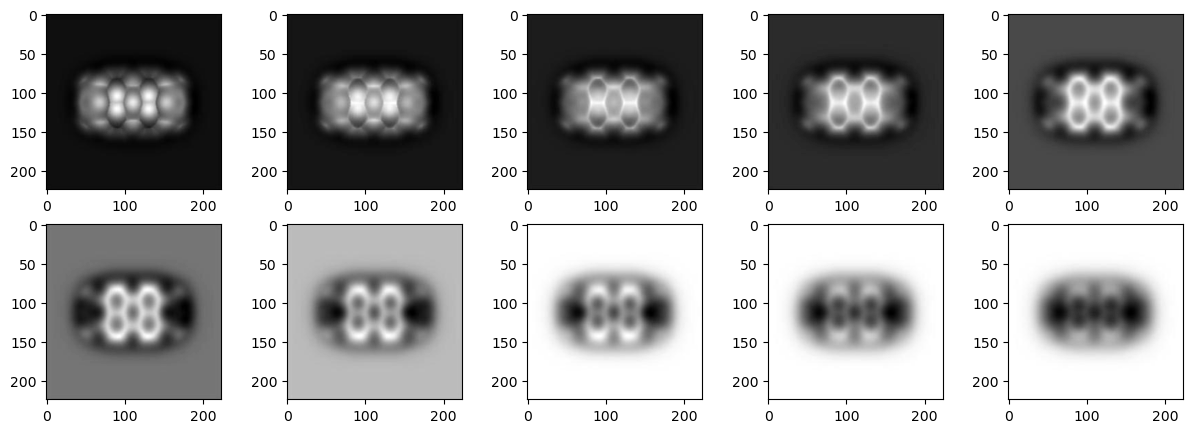

In [5]:
CID = 67191
molec_path = '/scratch/dataset/quam/K-1/Conformer3D_CID_67191_K040_Amp040'
img_stack = load_img_stack(molec_path)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')

They look the same as the ones I generated with PPM Jaime from df_002 to df_011

In [6]:
true_CID = 67191

fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)
print('Total number of fingerprints', np.sum(fp_pred))

output_df = fp_screening_function(fp_pred, dataset_df, top_k = 5, int_type=np.int8)

print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])
output_df

Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? False


path       CID  \
214687  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464606   
160541  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...     67191   
42345   /scratch/dataset/quam/K-1/Conformer3D_CID_6678...      6678   
173497  /scratch/dataset/quam/K-1/Conformer3D_CID_1185...    118580   
214688  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464610   

                                                   SMILES  \
214687  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
160541  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
42345         C1=CC2=C3C(=CC=C4C3=C1C(=O)OC4=O)C(=O)OC2=O   
173497  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
214688  C1=CC2=C3C(=C1)C4=C5C(=CC=C6C5=C(C=C4)C7=C8C6=...   

                                                morgan_fp  split  corrugation  \
214687  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0042   
160541  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108   
42345   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0019   
173497  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0074   
214688  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0129   

        tanimoto  
214687  1.000000  
160541  1.000000  
42345   0.777778  
173497  0.750000  
214688  0.750000

In [7]:
dataset_df[dataset_df['CID']==CID]['path'].iloc[0]


'/scratch/dataset/quam/K-1/Conformer3D_CID_67191_K040_Amp040'

/scratch/dataset/quam/K-1/Conformer3D_CID_67191_K040_Amp040
Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? False
top candidate: 59464606 tanimoto: 1.0
second candidate: 67191 tanimoto: 1.0
########################
214687    59464606
160541       67191
42345         6678
173497      118580
214688    59464610
Name: CID, dtype: int64
########################
67191 59464606 67191
/scratch/dataset/quam/K-1/Conformer3D_CID_67191_K040_Amp040
Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? False
top candidate: 59464606 tanimoto: 1.0
second candidate: 67191 tanimoto: 1.0
########################
214687    59464606
160541       67191
42345         6678
173497      118580
214688    59464610
Name: CID, dtype: int64
########################
67191 59464606 67191


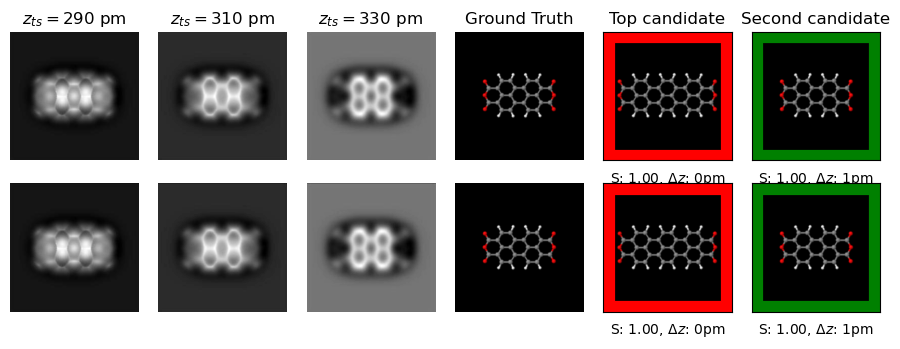

In [8]:
# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=2
molec_paths = [dataset_df[dataset_df['CID']==CID]['path'].iloc[0],
              dataset_df[dataset_df['CID']==CID]['path'].iloc[0]]
zoom_list = [1,1]
test_df = dataset_df

titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs
for i in range(n_results):
    MOLECULE_INDEX = i*40000 + 500
    molec_path = molec_paths[i]
    print(molec_path)
    zoom = zoom_list[i]
    img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=zoom, verbose=True)
    print(true_CID, first_CID, second_CID)
    corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
    corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(first_jmol)
    ax[i,5].imshow(second_jmol)


    if true_CID == first_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
   
    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     
    

    ax[i,4].add_patch(rect)
    ax[i,5].add_patch(rect_2)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
#plt.savefig('identification_3_cases_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()

In [9]:
from utils.models import resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, regressor_from_checkpoint, \
                            AtomCountPredictor



device='cpu'




# model and metrics initialization
criterion = nn.MSELoss()


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/regression_w_H/models'
checkpoint_path = os.path.join(models_path, 'checkpoint_2_virtual_epoch_1.pth')

pretrained_model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)
model = AtomCountPredictor(pretrained_model, output_size=args.output_size).to(device)

checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_path = f'/home/{USER}/QUAM-AFM/datasets/atoms_count_w_H_df.gz'
dataset_df = pd.read_pickle(data_path)

print('Finished')

Finished


In [10]:
exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    atom_count = torch.round(predictions) 
    print(atom_count.size())

atom_count = atom_count.cpu().numpy().astype(int).squeeze()
for atom, count in zip(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'], atom_count):
    print(atom, ':', count)
print(f'Total atoms: {atom_count.sum()}')

torch.Size([1, 10, 224, 224])
torch.Size([10])
torch.Size([10])
C : 24
Br : 0
Cl : 0
F : 0
I : 0
N : 0
O : 6
P : 0
S : 0
H : 8
Total atoms: 38


Perfect prediction of the chemical formula

### Porphycene

In [21]:
# FOR CPU
# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'), map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

data_path = f'/home/{USER}/QUAM-AFM/datasets/285k_train_15k_val_test_1024bits_df.gz'
dataset_df = pd.read_pickle(data_path)

                                                     path     CID  \
176727  /scratch/dataset/quam/K-1/Conformer3D_CID_1276...  127650   

                                                   SMILES  \
176727  C1=CC2=CC=C(N2)C3=CC=C(N3)C=CC4=NC(=C5C=CC1=N5...   

                                                morgan_fp split  corrugation  
176727  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.7489  


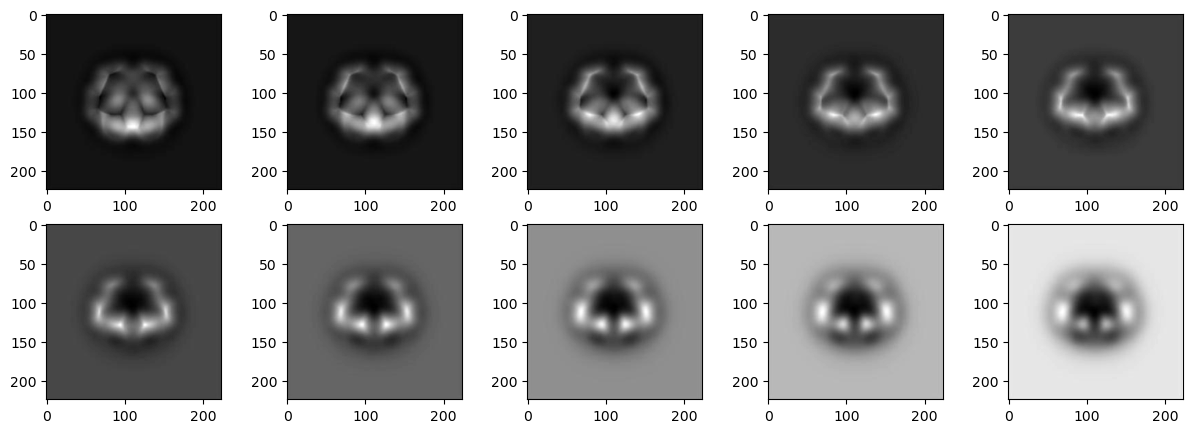

In [22]:
print(dataset_df[dataset_df['CID']==CID])
CID = 127650
molec_path = dataset_df[dataset_df['CID']==CID]['path'].iloc[0]
img_stack = load_img_stack(molec_path)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')

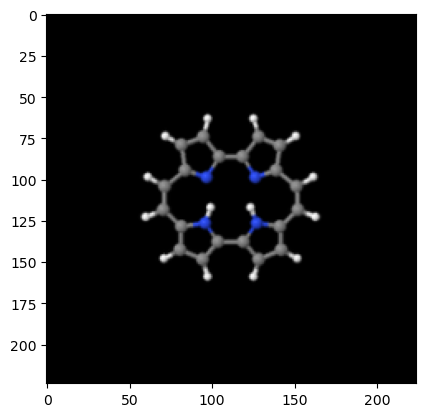

In [23]:
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

In [24]:
true_CID = 127650

fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)
print('Total number of fingerprints', np.sum(fp_pred))

output_df = fp_screening_function(fp_pred, dataset_df, int_type=np.int8)

print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])
output_df

Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? False


path        CID  \
124510  /scratch/dataset/quam/K-1/Conformer3D_CID_5481...    5481287   
33332   /scratch/dataset/quam/K-1/Conformer3D_CID_5840...   58409740   
17215   /scratch/dataset/quam/K-1/Conformer3D_CID_1367...  136726635   
88988   /scratch/dataset/quam/K-1/Conformer3D_CID_1369...  136915381   
190422  /scratch/dataset/quam/K-1/Conformer3D_CID_1363...  136393214   
...                                                   ...        ...   
96922   /scratch/dataset/quam/K-1/Conformer3D_CID_1362...   13620965   
96926   /scratch/dataset/quam/K-1/Conformer3D_CID_1360...  136099463   
454147  /scratch/dataset/quam/K-1/Conformer3D_CID_1297...  129763225   
454067  /scratch/dataset/quam/K-1/Conformer3D_CID_1297...  129770633   
107404  /scratch/dataset/quam/K-1/Conformer3D_CID_5872...   58729875   

                                                   SMILES  \
124510  C1=CC2=NC1=CC3=NC(=CC4=NC(=CC5=NC(=C2)C=C5)C=C...   
33332   C1C2=CC3=NC(=CC4=NC(=CC5=CC=C(N5)C=C1C=C2)C=C4...   
17215   C1=CC2=CC3=CC=C(N3)C=C4C=CC(=N4)C=C5C=CC(=N5)C...   
88988   C1=CC2=NC1=CC3=CC=C(N3)C=C4C=CC(=N4)C(=CO)C5=N...   
190422  C1=CC2=NC1=CC3=CC=C(N3)C=C4C=CC(=N4)C(=C5NC=CN...   
...                                                   ...   
96922                           C(N=[N+]=[N-])N=[N+]=[N-]   
96926                               CCOC(=O)C(=C=N)C(=O)C   
454147                                           C=CC=NCl   
454067                            C(=C([N+](=O)[O-])Br)NN   
107404                                      COCNC(=S)NN=C   

                                                morgan_fp  split  corrugation  \
124510  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0040   
33332   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  train       0.6271   
17215   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.8982   
88988   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       1.1187   
190422  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       1.2693   
...                                                   ...    ...          ...   
96922   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0141   
96926   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0008   
454147  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    val       0.0001   
454067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0707   
107404  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...   test       0.0242   

        tanimoto  
124510  0.409091  
33332   0.393939  
17215   0.325000  
88988   0.324324  
190422  0.315789  
...          ...  
96922   0.000000  
96926   0.000000  
454147  0.000000  
454067  0.000000  
107404  0.000000  

[579905 rows x 7 columns]

In [25]:
output_df[output_df['CID']==true_CID]

path     CID  \
176727  /scratch/dataset/quam/K-1/Conformer3D_CID_1276...  127650   

                                                   SMILES  \
176727  C1=CC2=CC=C(N2)C3=CC=C(N3)C=CC4=NC(=C5C=CC1=N5...   

                                                morgan_fp split  corrugation  \
176727  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.7489   

        tanimoto  
176727  0.205882

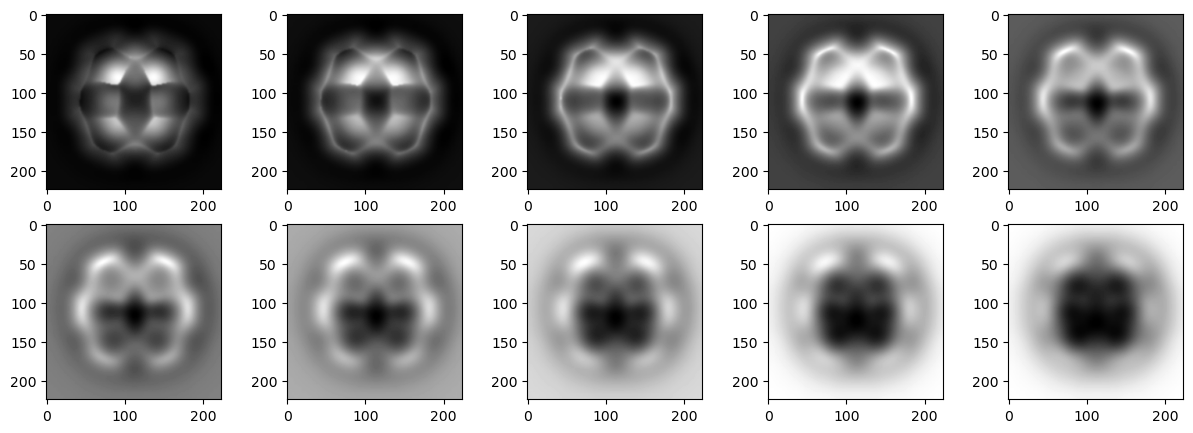

In [26]:
## From our calculation
molec_path = '/home/mgonzalez/porphycene_ppm_jaime/K1'
img_stack = load_exp_img_stack(molec_path, zoom=1.15)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')

In [27]:
true_CID = 127650
exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.15, interpolation='bilinear')

with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print('Total number of fingerprints', np.sum(exp_fp))

output_df = fp_screening_function(exp_fp, dataset_df, int_type=np.int8)

print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])


torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? False


In [28]:
output_df

path        CID  \
63219   /scratch/dataset/quam/K-1/Conformer3D_CID_1377...  137705241   
204596  /scratch/dataset/quam/K-1/Conformer3D_CID_3140...     314051   
77603   /scratch/dataset/quam/K-1/Conformer3D_CID_6686...      66868   
190986  /scratch/dataset/quam/K-1/Conformer3D_CID_1365...  136502079   
188169  /scratch/dataset/quam/K-1/Conformer3D_CID_1359...  135977809   
...                                                   ...        ...   
100817  /scratch/dataset/quam/K-1/Conformer3D_CID_2356...   23568533   
6506    /scratch/dataset/quam/K-1/Conformer3D_CID_1266...  126625008   
40736   /scratch/dataset/quam/K-1/Conformer3D_CID_1236...  123656811   
549618  /scratch/dataset/quam/K-1/Conformer3D_CID_5381...   53813780   
27020   /scratch/dataset/quam/K-1/Conformer3D_CID_5853...   58537889   

                                                   SMILES  \
63219   C1=CC2=CC3=NC(=CC4=CC=C(N4)C=C5C=CC(=N5)C=C1N2...   
204596         C1=CC2=C3C=CC(=O)C=C3C=CC2=C4C1=CC(=O)C=C4   
77603   C1=CC2=CC3=CC=C(N3)C=C4C=CC(=N4)C=C5C=CC(=N5)C...   
190986  C1=CC2=NC1=CC3=CC=C(N3)NC4=NC(=CC5=CC=C(N2)N5)...   
188169  C1=CC2=NC1=CC3=CC=C(N3)C=C4C=CC(=N4)NC5=CC=C(N...   
...                                                   ...   
100817                             [C-]#[N+]C(=N)C(=N)C#N   
6506                                         CC(=S)OCCNCS   
40736                                            CNCCNCNN   
549618                                          C(COCBr)O   
27020                                            CC(=CO)O   

                                                morgan_fp  split  corrugation  \
63219   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0324   
204596  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0042   
77603   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.9018   
190986  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0036   
188169  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0054   
...                                                   ...    ...          ...   
100817  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0009   
6506    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   test       0.0260   
40736   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0221   
549618  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  train       0.0380   
27020   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0002   

        tanimoto  
63219   0.285714  
204596  0.275862  
77603   0.266667  
190986  0.264706  
188169  0.264706  
...          ...  
100817  0.000000  
6506    0.000000  
40736   0.000000  
549618  0.000000  
27020   0.000000  

[579905 rows x 7 columns]

In [30]:
output_df[output_df['CID']==true_CID]

path     CID  \
176727  /scratch/dataset/quam/K-1/Conformer3D_CID_1276...  127650   

                                                   SMILES  \
176727  C1=CC2=CC=C(N2)C3=CC=C(N3)C=CC4=NC(=C5C=CC1=N5...   

                                                morgan_fp split  corrugation  \
176727  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.7489   

        tanimoto  
176727  0.171429

## Check molecules in training set that are similar to porphycene.

In [34]:
true_CID = 127650
porphycene_fp = dataset_df[dataset_df['CID']==true_CID]['morgan_fp'].iloc[0]
output_df = fp_screening_function(porphycene_fp, dataset_df[dataset_df['split']=='train'], int_type=np.int8)
output_df

path        CID  \
63219   /scratch/dataset/quam/K-1/Conformer3D_CID_1377...  137705241   
77603   /scratch/dataset/quam/K-1/Conformer3D_CID_6686...      66868   
396558  /scratch/dataset/quam/K-1/Conformer3D_CID_2206...   22061822   
468876  /scratch/dataset/quam/K-1/Conformer3D_CID_1405...   14055349   
401038  /scratch/dataset/quam/K-1/Conformer3D_CID_8566...   85664994   
...                                                   ...        ...   
54906   /scratch/dataset/quam/K-1/Conformer3D_CID_6959...      69599   
6495    /scratch/dataset/quam/K-1/Conformer3D_CID_1605...     160542   
157199  /scratch/dataset/quam/K-1/Conformer3D_CID_1373...   13738264   
226889  /scratch/dataset/quam/K-1/Conformer3D_CID_8235...   82358534   
515780  /scratch/dataset/quam/K-1/Conformer3D_CID_8727...   87276875   

                                                   SMILES  \
63219   C1=CC2=CC3=NC(=CC4=CC=C(N4)C=C5C=CC(=N5)C=C1N2...   
77603   C1=CC2=CC3=CC=C(N3)C=C4C=CC(=N4)C=C5C=CC(=N5)C...   
396558  C1=CC2=CC3=CC(=C(N3)C=C4C=CC(=N4)C=C5C=CC(=N5)...   
468876  C1=CC2=CC3=CC(=C(N3)C=C4C=CC(=N4)C=C5C=CC(=N5)...   
401038  C1=CC2=C(C3=CC=C(N3)C(=C4C=CC(=N4)C(=C5C=CC(=N...   
...                                                   ...   
54906                                       COC=C(C#N)C#N   
6495                                           C(=O)(N)ON   
157199                                   CC(=O)CCCCC(=O)N   
226889                                     CCCOC(=O)CNCCO   
515780                                C(=C(F)F)(C(=O)O)OF   

                                                morgan_fp  split  corrugation  \
63219   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0324   
77603   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.9018   
396558  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       1.3236   
468876  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       1.2841   
401038  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.8979   
...                                                   ...    ...          ...   
54906   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.5413   
6495    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0001   
157199  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0306   
226889  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...  train       0.0336   
515780  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.5770   

        tanimoto  
63219   0.413793  
77603   0.387097  
396558  0.368421  
468876  0.368421  
401038  0.363636  
...          ...  
54906   0.000000  
6495    0.000000  
157199  0.000000  
226889  0.000000  
515780  0.000000  

[285000 rows x 7 columns]

En el dataset son todo porfirinas. No hay porficinas casi. Es lógico que la red por default se vaya a porfirinas en vez de identificar porficinas.

In [35]:
true_CID = 127650
porphycene_fp = dataset_df[dataset_df['CID']==true_CID]['morgan_fp'].iloc[0]
output_df = fp_screening_function(porphycene_fp, dataset_df, int_type=np.int8)
output_df

path        CID  \
176727  /scratch/dataset/quam/K-1/Conformer3D_CID_1276...     127650   
149451  /scratch/dataset/quam/K-1/Conformer3D_CID_9906...    9906637   
87399   /scratch/dataset/quam/K-1/Conformer3D_CID_1360...  136010147   
63219   /scratch/dataset/quam/K-1/Conformer3D_CID_1377...  137705241   
77603   /scratch/dataset/quam/K-1/Conformer3D_CID_6686...      66868   
...                                                   ...        ...   
161737  /scratch/dataset/quam/K-1/Conformer3D_CID_3097...    3097518   
519550  /scratch/dataset/quam/K-1/Conformer3D_CID_1269...   12698018   
279826  /scratch/dataset/quam/K-1/Conformer3D_CID_1232...  123218479   
55985   /scratch/dataset/quam/K-1/Conformer3D_CID_3717...     371732   
160004  /scratch/dataset/quam/K-1/Conformer3D_CID_1189...  118963891   

                                                   SMILES  \
176727  C1=CC2=CC=C(N2)C3=CC=C(N3)C=CC4=NC(=C5C=CC1=N5...   
149451  C1=CC2=CC=C(N2)C3=NC(=C(C=C4C=CC(=C5C=CC1=N5)N...   
87399   C1=CC2=C3C=CC(=N3)C4=NC(=C5C=CC(=N5)C6=CC=C(N6...   
63219   C1=CC2=CC3=NC(=CC4=CC=C(N4)C=C5C=CC(=N5)C=C1N2...   
77603   C1=CC2=CC3=CC=C(N3)C=C4C=CC(=N4)C=C5C=CC(=N5)C...   
...                                                   ...   
161737                         CC(=O)NN=C(N)N[N+](=O)[O-]   
519550                                     COC(=O)C=C(F)F   
279826                                         CC=NC(=C)F   
55985                                         CC(=N)N(C)O   
160004                                           CNCONC=O   

                                                morgan_fp  split  corrugation  \
176727  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.7489   
149451  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.8002   
87399   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    val       0.0288   
63219   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0324   
77603   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.9018   
...                                                   ...    ...          ...   
161737  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0320   
519550  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0013   
279826  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0005   
55985   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    val       0.1949   
160004  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...   test       0.0161   

        tanimoto  
176727  1.000000  
149451  0.538462  
87399   0.481481  
63219   0.413793  
77603   0.387097  
...          ...  
161737  0.000000  
519550  0.000000  
279826  0.000000  
55985   0.000000  
160004  0.000000  

[579905 rows x 7 columns]

# Prediction of the model from theoretical simulations of the experimental images

                                                     path    CID  \
160541  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...  67191   

                                                   SMILES  \
160541  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   

                                                morgan_fp  split  corrugation  
160541  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108  


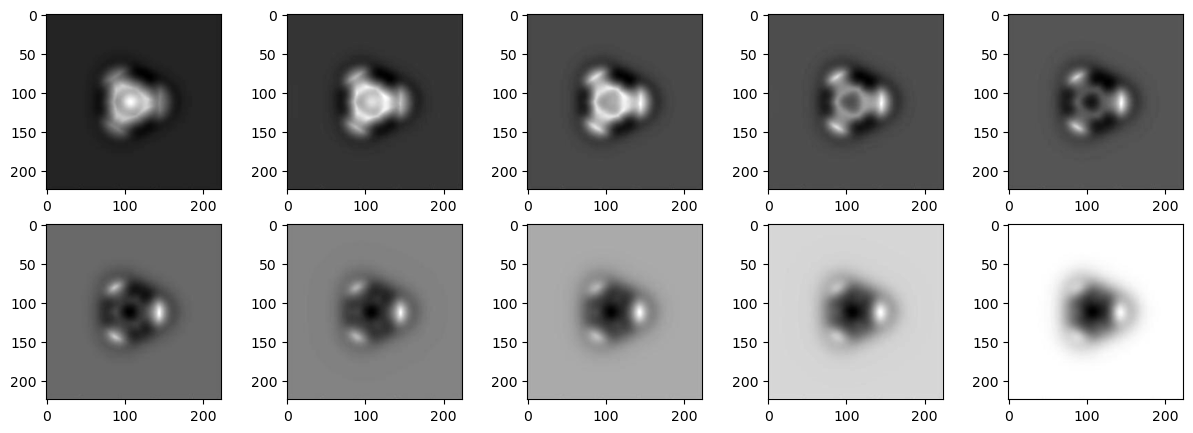

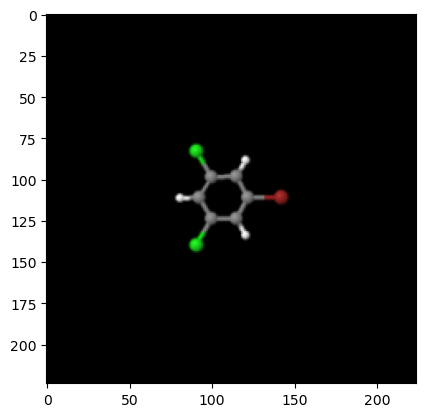

In [7]:
## HAY QUE GIRARLA

print(dataset_df[dataset_df['CID']==CID])
CID = 29766
molec_path = '/scratch/dataset/quam/K-6/Conformer3D_CID_29766_K040_Amp140'
img_stack = load_img_stack(molec_path)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

Empty DataFrame
Columns: [path, CID, SMILES, morgan_fp, split, corrugation]
Index: []


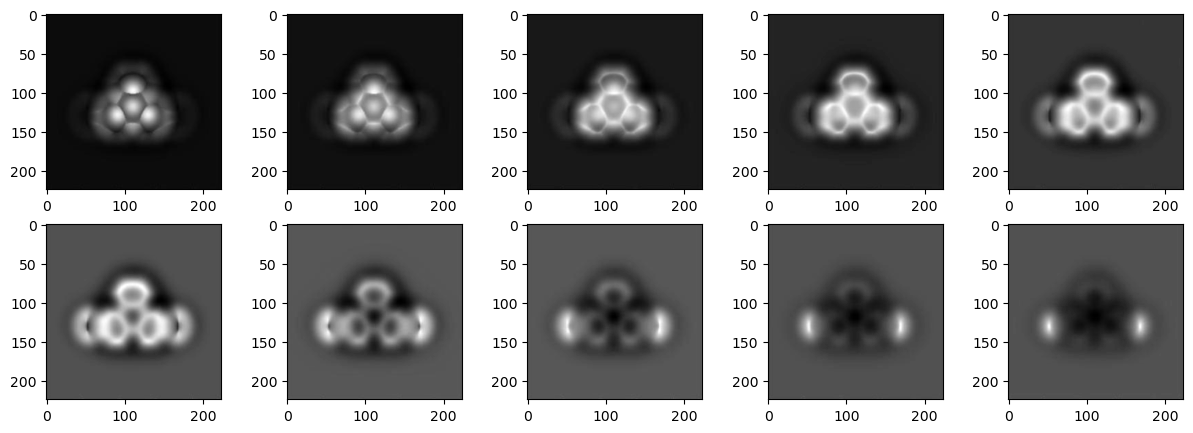

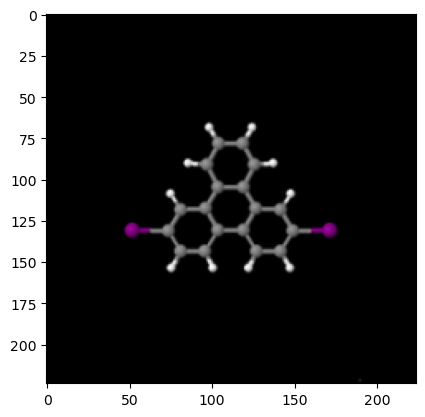

In [9]:
## 2-iodotriphenilene no está. Hay que hacerla a partir de esta 

print(dataset_df[dataset_df['CID']==CID])
CID = 130412167
molec_path = dataset_df[dataset_df['CID']==CID]['path'].iloc[0]
img_stack = load_img_stack(molec_path)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

                                                     path    CID  \
160541  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...  67191   

                                                   SMILES  \
160541  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   

                                                morgan_fp  split  corrugation  
160541  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108  


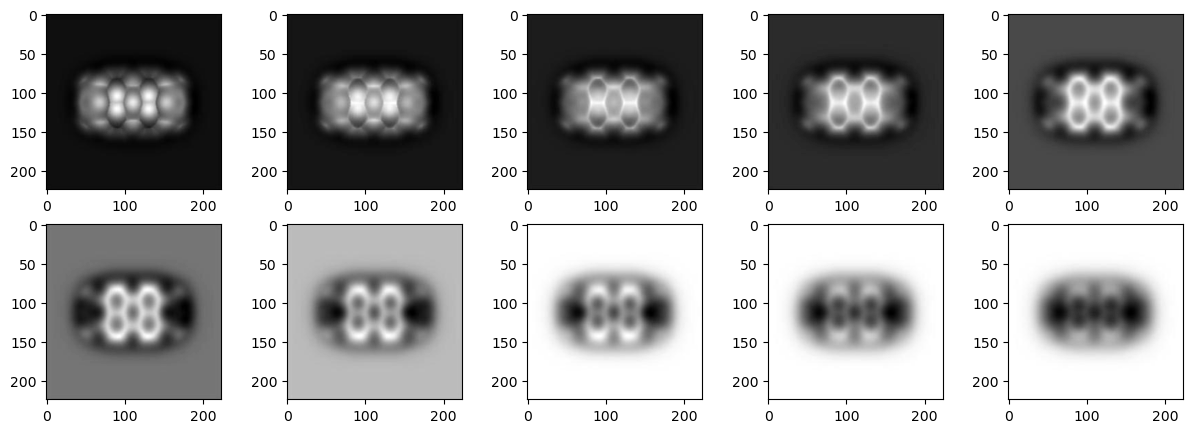

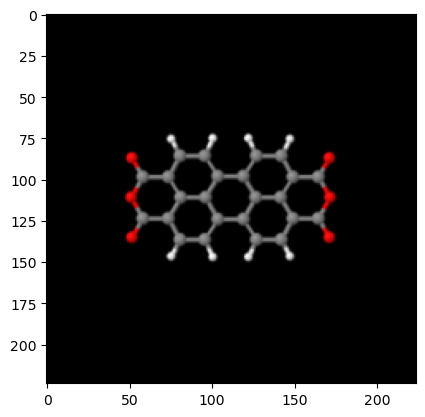

In [43]:
## PTCDA la tenemos en train

print(dataset_df[dataset_df['CID']==CID])
CID = 67191
molec_path = dataset_df[dataset_df['CID']==CID]['path'].iloc[0]
img_stack = load_img_stack(molec_path)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

Empty DataFrame
Columns: [path, CID, SMILES, morgan_fp, split, corrugation]
Index: []


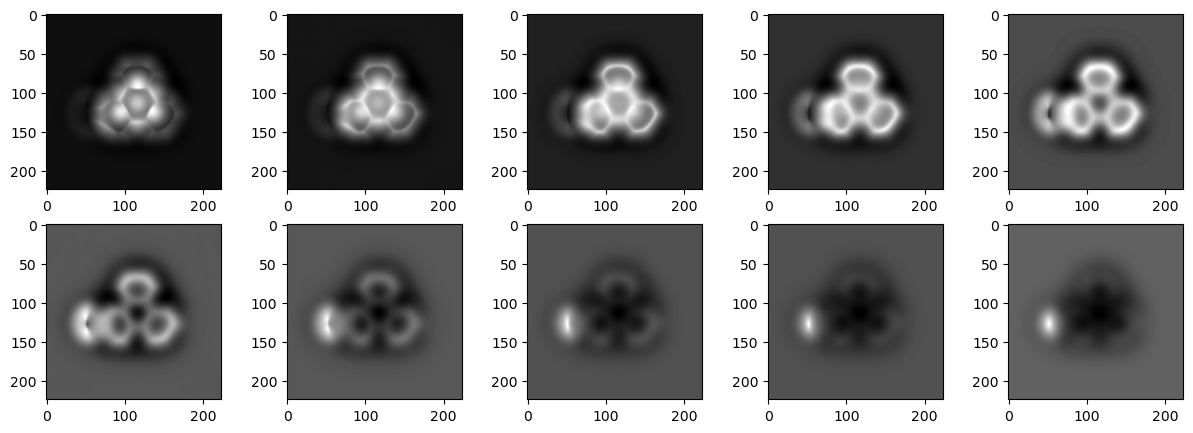

AttributeError: 'tuple' object has no attribute 'read'

In [8]:
# 2-iodotriphenylene relaxed

CID = 88955426

print(dataset_df[dataset_df['CID']==CID])
molec_path = "/home/mgonzalez/2-iodotriphenylene-ppm-jaime/imgs_rlx/K1"
img_stack = load_exp_img_stack(molec_path, zoom=1.2)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_path = '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg',
jmol_img = load_jmol(jmol_path)
plt.imshow(jmol_img)

In [9]:
CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan
path = "/aaa"


experimental_df = dataset_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

/tmp/ipykernel_246196/2554164604.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = dataset_df.append({'path':path,


path        CID  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   10000010   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   10001048   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   10001815   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  100027166   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  100027208   
...                                                   ...        ...   
579901  /scratch/dataset/quam/K-1/Conformer3D_CID_4419...   44193844   
579902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   53921077   
579903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   82382131   
579904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   82418146   
579905                                               /aaa   88955426   

                                                   SMILES  \
0       C1=CC=C(C=C1)C2=CC3=CC(=NC=C3O2)C(=O)NC4=C(C=C...   
1       C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...   
2       C1=C(C2=NO[N+](=C2C3=C1N4N=C5C(=[N+]4[N-]3)C=C...   
3                       CC1=CN(N=C1OCCCC(=O)O)C2=CC=CC=C2   
4                                CC1=C(N=CC=C1)NC(=O)CCCN   
...                                                   ...   
579901                  C1=CC(=CC(=C1)N2C=CC=N2)N3C=CC=N3   
579902                                  C1=CC(=CC=C1C=N)N   
579903            CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O   
579904                             C1=C(N=C(O1)C=O)C(=O)O   
579905         C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24   

                                                morgan_fp  split  corrugation  
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       1.1083  
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       1.1767  
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0069  
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  train       0.1112  
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0402  
...                                                   ...    ...          ...  
579901  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0016  
579902  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0008  
579903  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0034  
579904  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0057  
579905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test          NaN  

[579906 rows x 6 columns]

In [33]:
experimental_df[experimental_df['path'] == path]

path       CID                                      SMILES  \
579911  /aaa  88955426  C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24   

                                                morgan_fp split  corrugation  
579911  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN

In [10]:
CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan
path = "/aaa"


experimental_df = dataset_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df


exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
print('Is the correct CID the top candidate?',  CID == output_df['CID'].iloc[0])
output_df

/tmp/ipykernel_246196/895407917.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = dataset_df.append({'path':path,


torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
25
Is the correct CID in the top k candidates? True
Is the correct CID the top candidate? True


path        CID  \
579905                                               /aaa   88955426   
275257  /scratch/dataset/quam/K-1/Conformer3D_CID_1304...  130412167   
394850  /scratch/dataset/quam/K-1/Conformer3D_CID_8885...   88850427   
68534   /scratch/dataset/quam/K-1/Conformer3D_CID_1357...     135719   
320254  /scratch/dataset/quam/K-1/Conformer3D_CID_1320...  132093176   

                                               SMILES  \
579905     C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24   
275257  C1=CC=C2C(=C1)C3=C(C=CC(=C3)I)C4=C2C=C(C=C4)I   
394850     C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=NC=CN=C24   
68534   C1=CC=C2C(=C1)C3=CC=CC=C3C4=C2C=C5C=CN=CC5=C4   
320254       C1=CC=C2C(=C1)C=CC3=C2C=CC4=C3C=C(C=C4)I   

                                                morgan_fp split  corrugation  \
579905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN   
275257  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0025   
394850  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0012   
68534   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0007   
320254  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0008   

        tanimoto  
579905  0.680000  
275257  0.680000  
394850  0.562500  
68534   0.516129  
320254  0.516129

In [24]:
exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1, interpolation='bilinear')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

output_df = fp_screening_function(exp_fp, experimental_df)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df[output_df['CID'] == CID]

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
25
Is the correct CID in the top k candidates? True


path       CID                                      SMILES  \
579909  /aaa  88955426  C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24   

                                                morgan_fp split  corrugation  \
579909  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN   

        tanimoto  
579909      0.68

In [29]:
molec_path = "/home/mgonzalez/2-iodotriphenylene-ppm-jaime/imgs_rlx/K4"

for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) >= 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))


Interpolation method: bilinear
zoom: 0.5 tanimoto 0.16
zoom: 0.6 tanimoto 0.24
zoom: 0.7 tanimoto 0.09
zoom: 0.8 tanimoto 0.0
zoom: 0.9 tanimoto 0.24
zoom: 1 tanimoto 0.52
zoom: 1.1 tanimoto 0.62
zoom: 1.2 tanimoto 0.68
zoom: 1.3 tanimoto 0.71
zoom: 1.4 tanimoto 0.71
zoom: 1.5 tanimoto 0.73
Interpolation method: nearest
zoom: 0.5 tanimoto 0.16
zoom: 0.6 tanimoto 0.24
zoom: 0.7 tanimoto 0.09
zoom: 0.8 tanimoto 0.0
zoom: 0.9 tanimoto 0.24
zoom: 1 tanimoto 0.52
zoom: 1.1 tanimoto 0.62
zoom: 1.2 tanimoto 0.68
zoom: 1.3 tanimoto 0.71
zoom: 1.4 tanimoto 0.71
zoom: 1.5 tanimoto 0.73
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.16
zoom: 0.6 tanimoto 0.24
zoom: 0.7 tanimoto 0.09
zoom: 0.8 tanimoto 0.0
zoom: 0.9 tanimoto 0.24
zoom: 1 tanimoto 0.52
zoom: 1.1 tanimoto 0.62
zoom: 1.2 tanimoto 0.68
zoom: 1.3 tanimoto 0.71
zoom: 1.4 tanimoto 0.71
zoom: 1.5 tanimoto 0.73


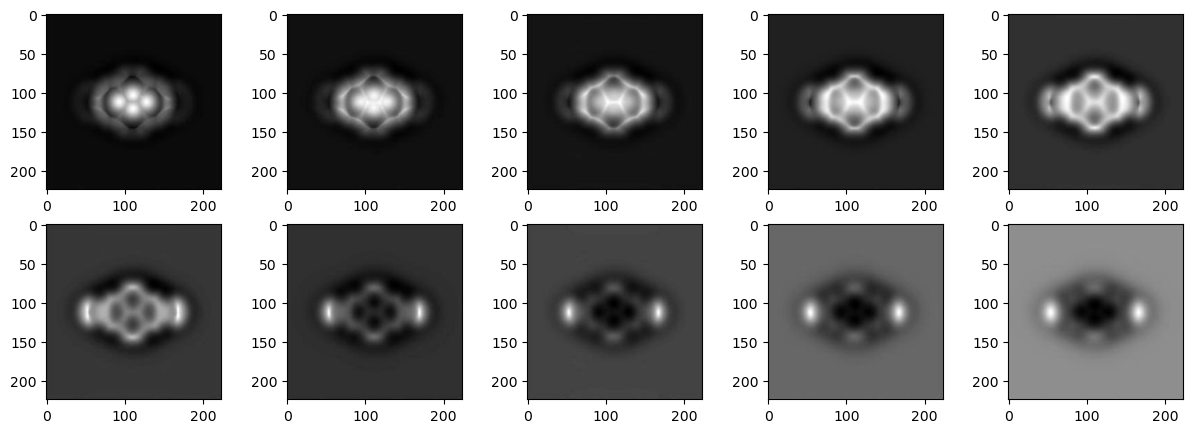

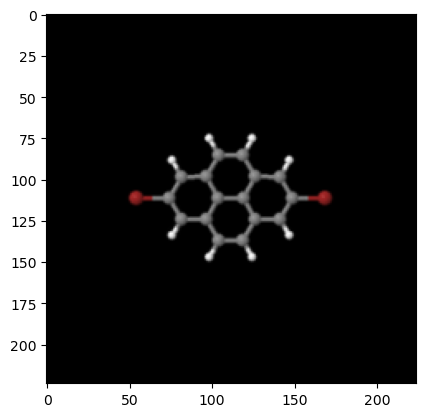

In [61]:
## Dibromopyrene

CID = 13615479

molec_path = dataset_df[dataset_df['CID']==CID]['path'].iloc[0]
img_stack = load_img_stack(molec_path)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

## Final figure 
We first plot the 3 molecules present in the dataset

In [107]:
test_df = dataset_df.copy()
test_df[test_df['CID']==67191]


path    CID  \
160541  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...  67191   

                                                   SMILES  \
160541  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   

                                                morgan_fp  split  corrugation  
160541  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108

/scratch/dataset/quam/K-6/Conformer3D_CID_29766_K040_Amp140
Total number of fingerprints 14
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 29766 tanimoto: 0.9285714285714286
second candidate: 84676 tanimoto: 0.9285714285714286
########################
338740       29766
340495       84676
327335    23341361
576576    51000077
489446     3084709
Name: CID, dtype: int64
########################
29766 29766 84676
/scratch/dataset/quam/K-1/Conformer3D_CID_67191_K040_Amp040
Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 67191 tanimoto: 1.0
second candidate: 59464606 tanimoto: 1.0
########################
-1            67191
 214688    59464606
 0         59464606
 160542       67191
 42346         6678
Name: CID, dtype: int64
########################
67191 67191 59464606
/scratch/dataset/quam/K-19/Conformer3D_CID_13615479_K100_Amp040
Tot

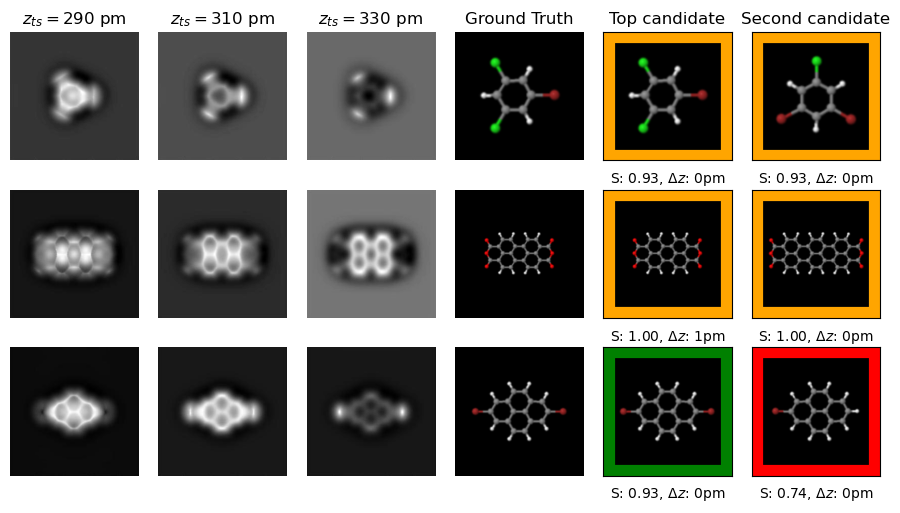

In [11]:
# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=3
molec_paths = ['/scratch/dataset/quam/K-6/Conformer3D_CID_29766_K040_Amp140',  
         '/scratch/dataset/quam/K-1/Conformer3D_CID_67191_K040_Amp040',
        '/scratch/dataset/quam/K-19/Conformer3D_CID_13615479_K100_Amp040',]
zoom_list = [0.5, 1.05, 0.75]
test_df = dataset_df
test_df.loc[-2] = test_df[test_df['CID']==67191].iloc[0] # reorder ptcda
test_df.loc[-1] = test_df[test_df['CID']==59464606].iloc[0] # reorder the other candidate


test_df.index = test_df.index + 1  # shifting index
test_df = test_df.sort_index()  # sorting by index

titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs
for i in range(n_results):
    MOLECULE_INDEX = i*40000 + 500
    molec_path = molec_paths[i]
    print(molec_path)
    zoom = zoom_list[i]
    img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=zoom, verbose=True)
    print(true_CID, first_CID, second_CID)
    corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
    corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(first_jmol)
    ax[i,5].imshow(second_jmol)


    if true_CID == first_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
   
    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     
   
    if tanimoto_first == tanimoto_second:
        
        color = 'orange'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    ax[i,4].add_patch(rect)
    ax[i,5].add_patch(rect_2)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
##plt.savefig('identification_3_cases_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()

Empty DataFrame
Columns: [path, CID, SMILES, morgan_fp, split, corrugation]
Index: []


/tmp/ipykernel_447369/2318609217.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = dataset_df.append({'path':path,


torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
25
88955426 130412167


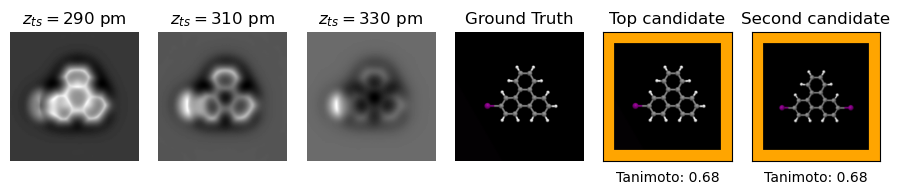

In [97]:
## AHora la última, el 2-iodotriphenylene

# Final figure:
n_results=1
print(dataset_df[dataset_df['CID']==CID])
CID = 88955426
molec_path = "/home/mgonzalez/2-iodotriphenylene-ppm-jaime/imgs_rlx/K4"
exp_img = load_exp_img_stack(molec_path, zoom=1.2)

jmol_path = '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg'
jmol_img = load_jmol(jmol_path)

CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan
path = "/aaa"


experimental_df = dataset_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df


exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)


titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*2.1))  # Adjust figsize according to your needs
    
    

img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

gt_jmol = rotate_image(jmol_img, angle=-60)

pred_CID, second_CID = output_df.iloc[0:2]['CID']
tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
print(pred_CID, second_CID)

pred_jmol = rotate_image(jmol_img, angle=-60)
second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=1)


ax[0].imshow(img_1, cmap='gray')
ax[0].axis('off')
ax[1].imshow(img_3, cmap='gray')
ax[1].axis('off')
ax[2].imshow(img_5, cmap='gray')
ax[2].axis('off')
ax[3].imshow(gt_jmol)
ax[3].axis('off')
ax[4].imshow(pred_jmol)
ax[5].imshow(second_jmol)



if tanimoto == tanimoto_second:
        
    color = 'orange'
    rect = patches.Rectangle((0, 0), pred_jmol.shape[0], pred_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')
    rect_2 = patches.Rectangle((0, 0), second_jmol.shape[0], second_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')


ax[4].add_patch(rect)
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs


ax[5].add_patch(rect_2)
ax[5].set_xticks([])
ax[5].set_yticks([])
ax[5].set_xlabel(f'Tanimoto: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs

# Setting titles for each column

for j in range(6):
    ax[j].set_title(titles[j])

#######################################

plt.tight_layout()
###plt.savefig('vs_bad_pred.png')

plt.show()

/scratch/dataset/quam/K-14/Conformer3D_CID_29766_K080_Amp060
Total number of fingerprints 13
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 29766 tanimoto: 1.0
second candidate: 84676 tanimoto: 0.8571428571428571
########################
338746       29766
340501       84676
327341    23341361
576582    51000077
559935    22630180
Name: CID, dtype: int64
########################
29766 29766 84676
/scratch/dataset/quam/K-24/Conformer3D_CID_67191_K100_Amp140
Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 67191 tanimoto: 1.0
second candidate: 67191 tanimoto: 1.0
########################
-1            67191
 160548       67191
 1         59464606
 2         59464606
 3         59464606
Name: CID, dtype: int64
########################
67191 67191 67191
/scratch/dataset/quam/K-18/Conformer3D_CID_13615479_K080_Amp140
Total number of finger

/tmp/ipykernel_447369/3933388389.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = dataset_df.append({'path':path,


torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
25
88955426 130412167


/tmp/ipykernel_447369/3933388389.py:168: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ident_exp_molecules_theoretical_imgs.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_447369/3933388389.py:168: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ident_exp_molecules_theoretical_imgs.pdf', dpi=500, format='pdf', quality=120, optimize=True)


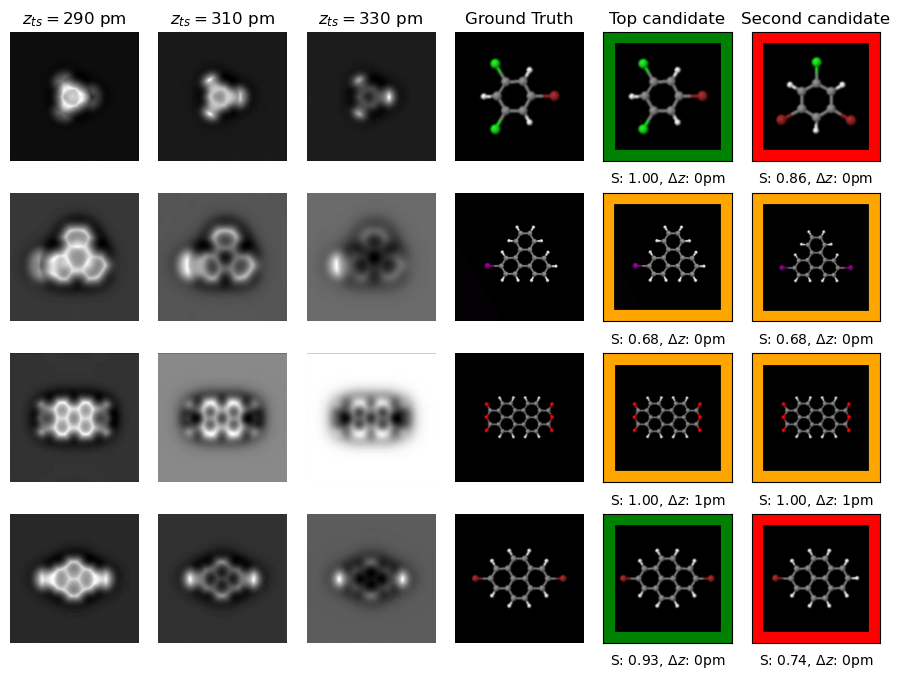

In [116]:
## Final figure

# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=4
molec_paths = ['/scratch/dataset/quam/K-14/Conformer3D_CID_29766_K080_Amp060',  
        '/scratch/dataset/quam/K-24/Conformer3D_CID_67191_K100_Amp140',
        '/scratch/dataset/quam/K-18/Conformer3D_CID_13615479_K080_Amp140']
zoom_list = [0.5, 1.05, 0.75]
test_df = dataset_df
test_df.loc[-2] = test_df[test_df['CID']==67191].iloc[0] # reorder ptcda
test_df.loc[-1] = test_df[test_df['CID']==59464606].iloc[0] # reorder the other candidate

reorder_dict = {0:0, 3:1, 1:2, 2:3} # to reorder the molecules in the plot

test_df.index = test_df.index + 1  # shifting index
test_df = test_df.sort_index()  # sorting by index

titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs
for i in range(n_results):
    if i < 3:
        
        molec_path = molec_paths[i]
        print(molec_path)
        zoom = zoom_list[i]
        img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=zoom, verbose=True)
        print(true_CID, first_CID, second_CID)
        corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
        corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
        ax[reorder_dict[i],0].imshow(img_1, cmap='gray')
        ax[reorder_dict[i],0].axis('off')
        ax[reorder_dict[i],1].imshow(img_3, cmap='gray')
        ax[reorder_dict[i],1].axis('off')
        ax[reorder_dict[i],2].imshow(img_5, cmap='gray')
        ax[reorder_dict[i],2].axis('off')
        ax[reorder_dict[i],3].imshow(gt_jmol)
        ax[reorder_dict[i],3].axis('off')
        ax[reorder_dict[i],4].imshow(first_jmol)
        ax[reorder_dict[i],5].imshow(second_jmol)

        if true_CID == first_CID:
            color = 'green'
            rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
        else:
            color = 'red'
            rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

        if true_CID == second_CID:
            color = 'green'
            rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
        else:
            color = 'red'
            rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     

        if tanimoto_first == tanimoto_second:

            color = 'orange'
            rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
            rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

        ax[reorder_dict[i],4].add_patch(rect)
        ax[reorder_dict[i],5].add_patch(rect_2)
        ax[reorder_dict[i],4].set_xticks([])
        ax[reorder_dict[i],4].set_yticks([])
        ax[reorder_dict[i],5].set_xticks([])
        ax[reorder_dict[i],5].set_yticks([])
        ax[reorder_dict[i],4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
        ax[reorder_dict[i],5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])
    
    if i == 3:
        CID = 88955426
        molec_path = "/home/mgonzalez/2-iodotriphenylene-ppm-jaime/imgs_rlx/K4"
        exp_img = load_exp_img_stack(molec_path, zoom=1.2)

        jmol_path = '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg'
        jmol_img = load_jmol(jmol_path)


        SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
        morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
        split='test'
        corrugation = np.nan
        path = "/aaa"


        experimental_df = dataset_df.append({'path':path,
                                   'CID':CID, 
                                   'SMILES':SMILES,
                                   'morgan_fp':morgan_fp,
                                   'split':split,
                                   'corrugation':corrugation
                                    }, ignore_index=True)


        exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
            print(batched_tensor.size())
            predictions = model(batched_tensor)
            print(predictions.size())
            fp_pred = (torch.sigmoid(predictions) > 0.5)
            print(fp_pred.size())

        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
        print(exp_fp.shape)
        print(exp_fp.sum())

        output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)


        



        img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

        gt_jmol = rotate_image(jmol_img, angle=-60)

        pred_CID, second_CID = output_df.iloc[0:2]['CID']
        tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
        print(pred_CID, second_CID)

        pred_jmol = rotate_image(jmol_img, angle=-60)
        second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=1)


        
        ax[reorder_dict[i],0].imshow(img_1, cmap='gray')
        ax[reorder_dict[i],0].axis('off')
        ax[reorder_dict[i],1].imshow(img_3, cmap='gray')
        ax[reorder_dict[i],1].axis('off')
        ax[reorder_dict[i],2].imshow(img_5, cmap='gray')
        ax[reorder_dict[i],2].axis('off')
        ax[reorder_dict[i],3].imshow(gt_jmol)
        ax[reorder_dict[i],3].axis('off')
        ax[reorder_dict[i],4].imshow(pred_jmol)
        ax[reorder_dict[i],5].imshow(second_jmol)
        


        if tanimoto == tanimoto_second:

            color = 'orange'
            rect = patches.Rectangle((0, 0), pred_jmol.shape[0], pred_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')
            rect_2 = patches.Rectangle((0, 0), second_jmol.shape[0], second_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')
        
        
                
        ax[reorder_dict[i],4].add_patch(rect)
        ax[reorder_dict[i],5].add_patch(rect_2)
        ax[reorder_dict[i],4].set_xticks([])
        ax[reorder_dict[i],4].set_yticks([])
        ax[reorder_dict[i],5].set_xticks([])
        ax[reorder_dict[i],5].set_yticks([])
        ax[reorder_dict[i],4].set_xlabel(f'S: {tanimoto:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
        ax[reorder_dict[i],5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

      

######################################

plt.tight_layout()
plt.savefig('ident_exp_molecules_theoretical_imgs.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()

# Compare PTCDA molecules
We already did gas phase with perfect results, let's check Ag substrate

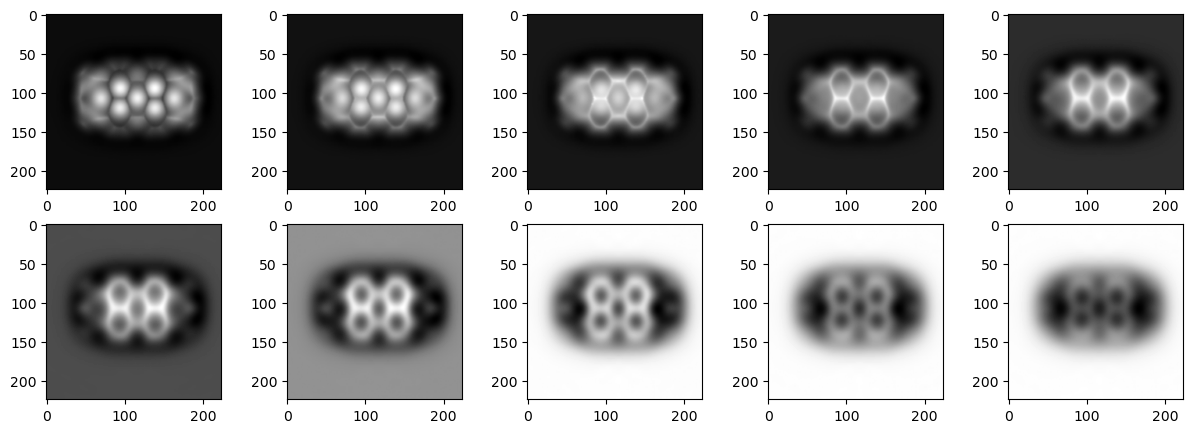

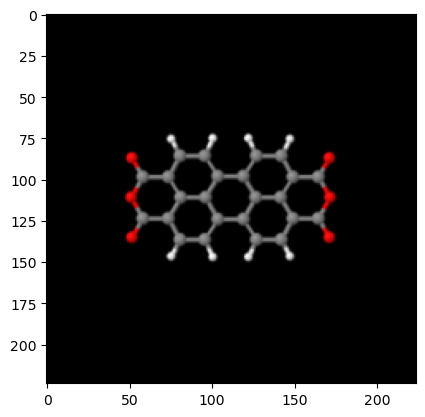

In [11]:
# PTCDA
experimental_df = dataset_df

CID = 67191
molec_path = "/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Cu/K1/"
img_stack = load_exp_img_stack(molec_path, zoom=1.2)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

In [11]:
molec_path = "/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_gas/K1"

exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
18
Is the correct CID in the top k candidates? True


path       CID  \
214687  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464606   
160541  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...     67191   
42345   /scratch/dataset/quam/K-1/Conformer3D_CID_6678...      6678   
173497  /scratch/dataset/quam/K-1/Conformer3D_CID_1185...    118580   
214688  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464610   

                                                   SMILES  \
214687  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
160541  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
42345         C1=CC2=C3C(=CC=C4C3=C1C(=O)OC4=O)C(=O)OC2=O   
173497  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
214688  C1=CC2=C3C(=C1)C4=C5C(=CC=C6C5=C(C=C4)C7=C8C6=...   

                                                morgan_fp  split  corrugation  \
214687  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0042   
160541  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108   
42345   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0019   
173497  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0074   
214688  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0129   

        tanimoto  
214687  1.000000  
160541  1.000000  
42345   0.777778  
173497  0.750000  
214688  0.750000

In [9]:
molec_path = "/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Ag/K1"
experimental_df = dataset_df.copy()
exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
18
Is the correct CID in the top k candidates? False


path        CID  \
101730  /scratch/dataset/quam/K-1/Conformer3D_CID_6647...      66475   
173497  /scratch/dataset/quam/K-1/Conformer3D_CID_1185...     118580   
145949  /scratch/dataset/quam/K-1/Conformer3D_CID_7977...      79771   
8403    /scratch/dataset/quam/K-1/Conformer3D_CID_1059...     105969   
24306   /scratch/dataset/quam/K-1/Conformer3D_CID_1320...  132017652   

                                                   SMILES  \
101730  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
173497  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
145949        C1=CC2=C3C(=CC=C4C3=C1C(=O)NC4=O)C(=O)NC2=O   
8403    CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   
24306   CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   

                                                morgan_fp  split  corrugation  \
101730  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0071   
173497  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0074   
145949  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0010   
8403    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0227   
24306   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0162   

        tanimoto  
101730   0.85000  
173497   0.75000  
145949   0.65000  
8403     0.62963  
24306    0.62963

In [13]:
molec_path = "/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_gas/K1"

exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

output_df = fp_screening_function(exp_fp, experimental_df)

output_df[output_df['CID']==CID]

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
18


path    CID  \
160541  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...  67191   

                                                   SMILES  \
160541  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   

                                                morgan_fp  split  corrugation  \
160541  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108   

        tanimoto  
160541       1.0

In [14]:
CID = 67191

gt_fp = dataset_df[dataset_df['CID']==CID]['morgan_fp'].iloc[0]


In [16]:
molec_path = "/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_gas/K1"

for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))


Interpolation method: bilinear
zoom: 0.5 tanimoto 0.05
zoom: 0.6 tanimoto 0.09
zoom: 0.7 tanimoto 0.04
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.35
zoom: 1 tanimoto 0.65
zoom: 1.1 tanimoto 0.94
zoom: 1.2 tanimoto 1.0
zoom: 1.3 tanimoto 1.0
zoom: 1.4 tanimoto 1.0
zoom: 1.5 tanimoto 1.0
Interpolation method: nearest
zoom: 0.5 tanimoto 0.05
zoom: 0.6 tanimoto 0.09
zoom: 0.7 tanimoto 0.04
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.35
zoom: 1 tanimoto 0.65
zoom: 1.1 tanimoto 0.94
zoom: 1.2 tanimoto 1.0
zoom: 1.3 tanimoto 1.0
zoom: 1.4 tanimoto 1.0
zoom: 1.5 tanimoto 1.0
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.05
zoom: 0.6 tanimoto 0.09
zoom: 0.7 tanimoto 0.04
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.35
zoom: 1 tanimoto 0.65
zoom: 1.1 tanimoto 0.94
zoom: 1.2 tanimoto 1.0
zoom: 1.3 tanimoto 1.0
zoom: 1.4 tanimoto 1.0
zoom: 1.5 tanimoto 1.0


                                                      path    CID  \
 160548  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...  67191   
 6       /scratch/dataset/quam/K-1/Conformer3D_CID_6719...  67191   
-1       /scratch/dataset/quam/K-1/Conformer3D_CID_6719...  67191   

                                                    SMILES  \
 160548  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
 6       C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
-1       C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   

                                                 morgan_fp  split  corrugation  
 160548  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108  
 6       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108  
-1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108  
torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
18
66475 118580


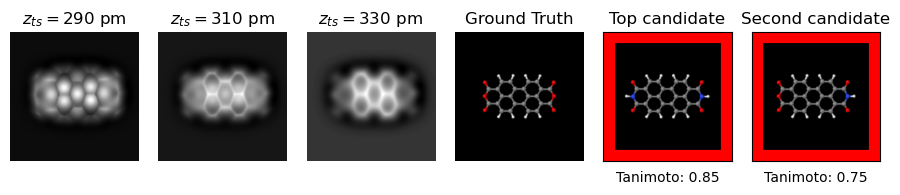

In [173]:
## Make identification figure for Ag
CID = 67191

# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=2
molec_paths = ['/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_gas/K1',  
        '/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Ag/K1']
molec_path = molec_paths[1]

# Final figure:
n_results=1
print(dataset_df[dataset_df['CID']==CID])
CID = 67191
true_CID = CID

exp_img = load_exp_img_stack(molec_path, zoom=1.2)

jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)




exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

output_df = fp_screening_function(exp_fp, dataset_df, top_k = 5)


titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*2.1))  # Adjust figsize according to your needs
    
    

img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

gt_jmol = rotate_image(jmol_img, angle=0)

pred_CID, second_CID = output_df.iloc[0:2]['CID']
tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
print(pred_CID, second_CID)

pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=1)
second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=1)


ax[0].imshow(img_1, cmap='gray')
ax[0].axis('off')
ax[1].imshow(img_3, cmap='gray')
ax[1].axis('off')
ax[2].imshow(img_5, cmap='gray')
ax[2].axis('off')
ax[3].imshow(gt_jmol)
ax[3].axis('off')
ax[4].imshow(pred_jmol)
ax[5].imshow(second_jmol)
 
if true_CID == pred_CID:
    color = 'green'
    rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
else:
    color = 'red'
    rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

if true_CID == second_CID:
    color = 'green'
    rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
else:
    color = 'red'
    rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')


if tanimoto == tanimoto_second:
        
    color = 'orange'
    rect = patches.Rectangle((0, 0), pred_jmol.shape[0], pred_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')
    rect_2 = patches.Rectangle((0, 0), second_jmol.shape[0], second_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')


ax[4].add_patch(rect)
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs


ax[5].add_patch(rect_2)
ax[5].set_xticks([])
ax[5].set_yticks([])
ax[5].set_xlabel(f'Tanimoto: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs

# Setting titles for each column

for j in range(6):
    ax[j].set_title(titles[j])

#######################################

plt.tight_layout()
###plt.savefig('vs_bad_pred.png')

plt.show()

In [21]:
experimental_df = dataset_df
experimental_df.loc[-2] = experimental_df[experimental_df['CID']==67191].iloc[0] # reorder ptcda
experimental_df.loc[-1] = experimental_df[experimental_df['CID']==59464606].iloc[0] # reorder the other candidate


experimental_df.index = experimental_df.index + 1  # shifting index
experimental_df = experimental_df.sort_index()  # sorting by index

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
18
                                                      path       CID  \
-1       /scratch/dataset/quam/K-1/Conformer3D_CID_6719...     67191   
 214688  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464606   
 0       /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464606   
 160542  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...     67191   
 42346   /scratch/dataset/quam/K-1/Conformer3D_CID_6678...      6678   

                                                    SMILES  \
-1       C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
 214688  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
 0       C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
 160542  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
 42346         C1=CC2=C3C(=CC=C4C3=C1C(=O)OC4=O)C(=O)OC2=O   

                                                 morgan_fp  split  \
-1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

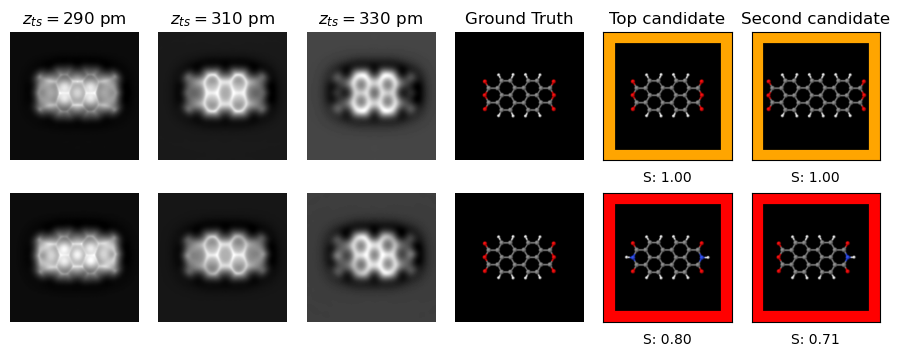

In [35]:
## Make identification figure for Ag
CID = 67191

# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=2
molec_paths = ['/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_gas/K14',  
        '/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Ag/K14']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.8))  # Adjust figsize according to your needs



# Final figure:


CID = 67191
true_CID = CID
for i in range(n_results):
    
    molec_path = molec_paths[i]
    exp_img = load_exp_img_stack(molec_path, zoom=1.2)

    jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)




    exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
    with torch.no_grad():
        batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
        print(batched_tensor.size())
        predictions = model(batched_tensor)
        print(predictions.size())
        fp_pred = (torch.sigmoid(predictions) > 0.5)
        print(fp_pred.size())

    exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
    print(exp_fp.shape)
    print(exp_fp.sum())

    output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)
    print(output_df)

    titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
    



    img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

    gt_jmol = rotate_image(jmol_img, angle=0)

    pred_CID, second_CID = output_df.iloc[0:2]['CID']
    tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
    print(pred_CID, second_CID)

    pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=1)
    second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=1)


    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(pred_jmol)
    ax[i,5].imshow(second_jmol)

    if true_CID == pred_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')


    if tanimoto == tanimoto_second:

        color = 'orange'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[0], pred_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')
        rect_2 = patches.Rectangle((0, 0), second_jmol.shape[0], second_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')


    ax[i,4].add_patch(rect)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].add_patch(rect_2)
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column

for j in range(6):
    ax[0,j].set_title(titles[j])

#######################################

plt.tight_layout()
#plt.savefig('ptcda_theoretical_gas_ag.pdf', dpi=500, format='pdf', quality=120, optimize=True)

plt.show()

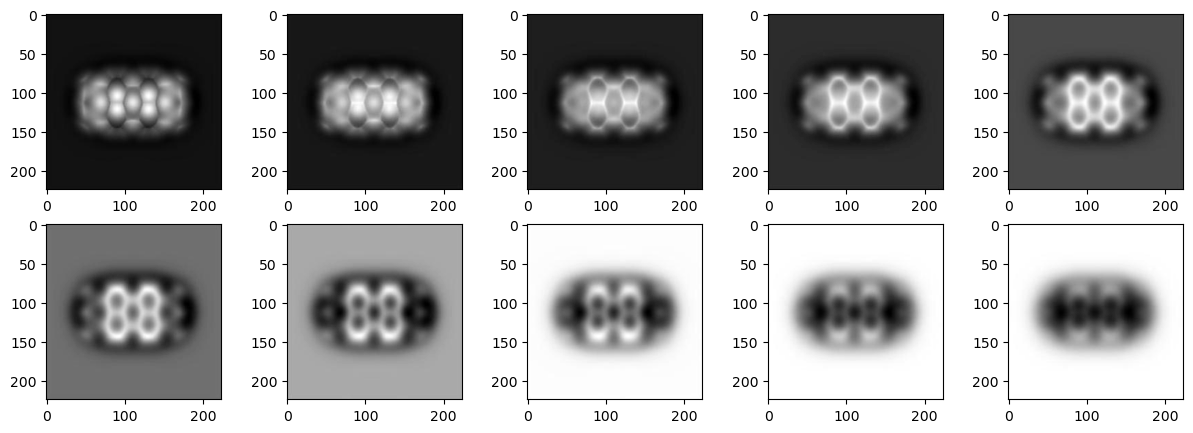

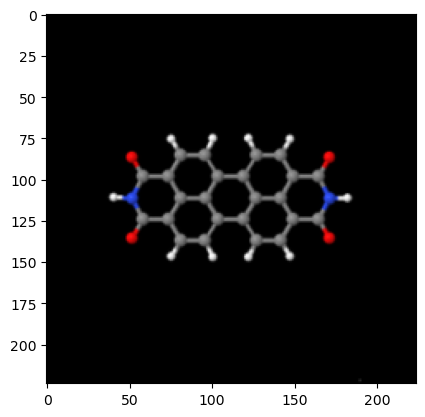

In [36]:
CID = 66475
molec_path = dataset_df[dataset_df['CID']==CID]['path'].iloc[0]
img_stack = load_img_stack(molec_path)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

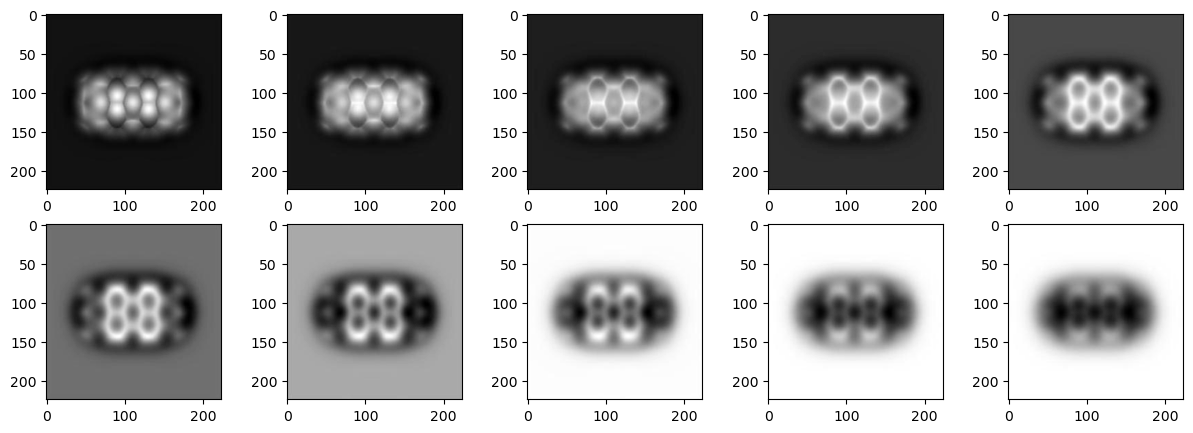

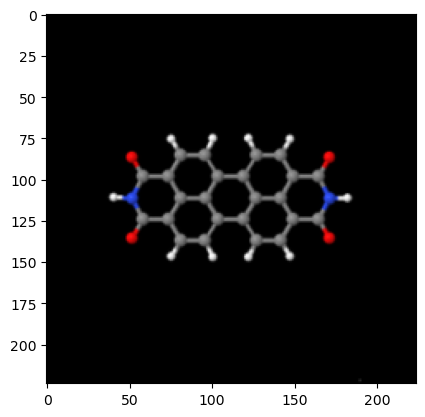

In [25]:
CID = 66475

molec_path = dataset_df[dataset_df['CID']==CID]['path'].iloc[0]
img_stack = load_img_stack(molec_path)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

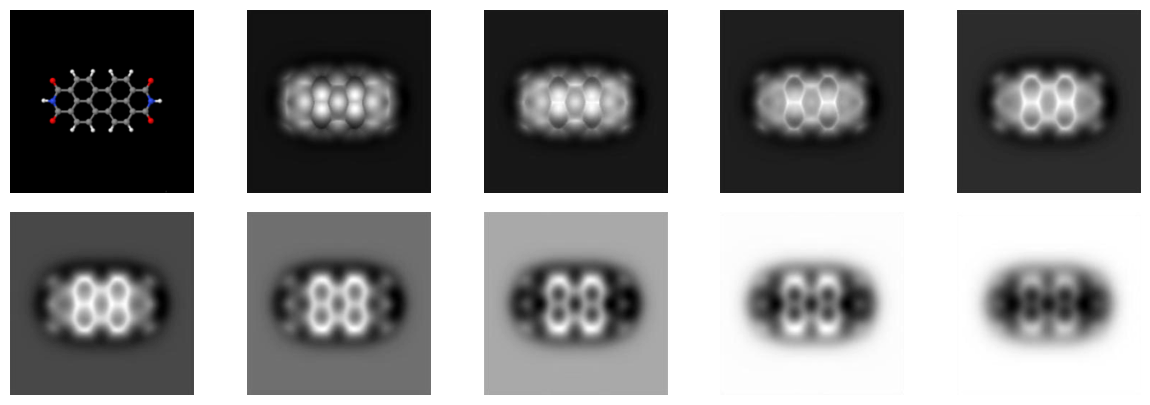

In [26]:
import matplotlib.pyplot as plt

# Assuming 'dataset_df' and 'load_img_stack' are already defined in your context
CID = 66475
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)

molec_path = dataset_df[dataset_df['CID'] == CID]['path'].iloc[0]
img_stack = load_img_stack(molec_path)

# Creating subplots
f, axarr = plt.subplots(2, 5, figsize=(15, 5))

# Adjusting layout for minimal spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Displaying each image in the grid
for i in range(2):
    for j in range(5):
        if i==j==0:
            axarr[i, j].imshow(jmol_img)
            axarr[i, j].axis('off')  # Hiding the axis labels
        else:
            axarr[i, j].imshow(img_stack[i * 5 + j-1], cmap='gray')
            axarr[i, j].axis('off')  # Hiding the axis labels



plt.show()


In [5]:
# PTCDA Cu
experimental_df = dataset_df

CID = 67191
molec_path = "/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Cu/K1"
img_stack = load_exp_img_stack(molec_path, zoom=1.2)
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(img_stack[0], cmap = 'gray')
axarr[0,1].imshow(img_stack[1], cmap = 'gray')
axarr[0,2].imshow(img_stack[2], cmap = 'gray')
axarr[0,3].imshow(img_stack[3], cmap = 'gray')
axarr[0,4].imshow(img_stack[4], cmap = 'gray')
axarr[1,0].imshow(img_stack[5], cmap = 'gray')
axarr[1,1].imshow(img_stack[6], cmap = 'gray')
axarr[1,2].imshow(img_stack[7], cmap = 'gray')
axarr[1,3].imshow(img_stack[8], cmap = 'gray')
axarr[1,4].imshow(img_stack[9], cmap = 'gray')
plt.show()
plt.close()
jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)
plt.imshow(jmol_img)

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [14]:
molec_path = "/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Cu/K14"
experimental_df = dataset_df.copy()
exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
25
Is the correct CID in the top k candidates? True


path       CID  \
160541  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...     67191   
214687  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464606   
173497  /scratch/dataset/quam/K-1/Conformer3D_CID_1185...    118580   
214688  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464610   
26199   /scratch/dataset/quam/K-1/Conformer3D_CID_1175...  11759069   

                                                   SMILES  \
160541  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
214687  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
173497  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
214688  C1=CC2=C3C(=C1)C4=C5C(=CC=C6C5=C(C=C4)C7=C8C6=...   
26199   C1=CC2=C3C(=C1)C4=C5C(=CC=C6C5=C(C=C4)C(=O)OC6...   

                                                morgan_fp  split  corrugation  \
160541  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0108   
214687  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   test       0.0042   
173497  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0074   
214688  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0129   
26199   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  train       0.0037   

        tanimoto  
160541  0.653846  
214687  0.653846  
173497  0.531250  
214688  0.531250  
26199   0.531250

### PTCDA Ag Cu Figure

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
18
                                                     path       CID  \
214687  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464606   
160541  /scratch/dataset/quam/K-1/Conformer3D_CID_6719...     67191   
42345   /scratch/dataset/quam/K-1/Conformer3D_CID_6678...      6678   
173497  /scratch/dataset/quam/K-1/Conformer3D_CID_1185...    118580   
214688  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...  59464610   

                                                   SMILES  \
214687  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
160541  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
42345         C1=CC2=C3C(=CC=C4C3=C1C(=O)OC4=O)C(=O)OC2=O   
173497  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
214688  C1=CC2=C3C(=C1)C4=C5C(=CC=C6C5=C(C=C4)C7=C8C6=...   

                                                morgan_fp  split  corrugation  \
214687  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/tmp/ipykernel_3666506/1907285477.py:111: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ptcda_theoretical_gas_ag_cu.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_3666506/1907285477.py:111: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ptcda_theoretical_gas_ag_cu.pdf', dpi=500, format='pdf', quality=120, optimize=True)


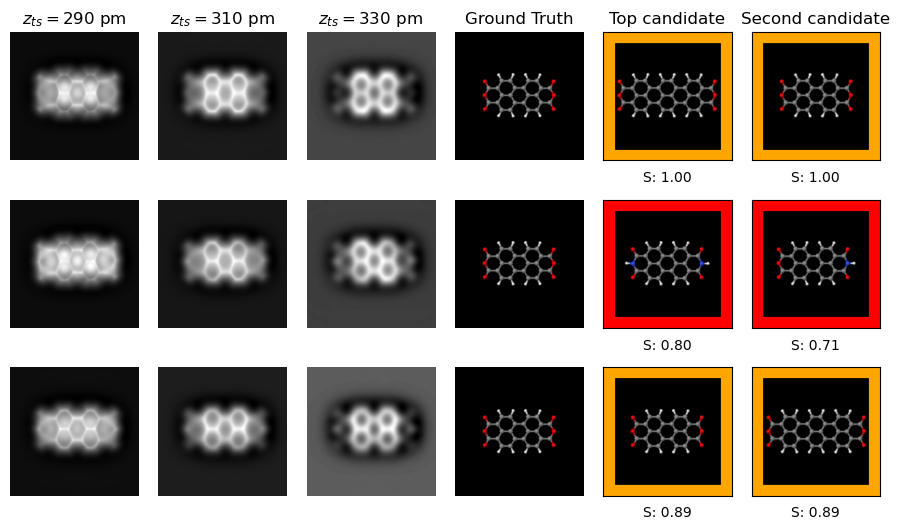

In [18]:
## Make identification figure for gas, Ag, Cu
CID = 67191

# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=3
molec_paths = ['/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_gas/K14',  
        '/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Ag/K14', 
              '/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Cu/K14']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.8))  # Adjust figsize according to your needs



# Final figure:


CID = 67191
true_CID = CID
for i in range(n_results):
    
    molec_path = molec_paths[i]
    exp_img = load_exp_img_stack(molec_path, zoom=1.2)

    jmol_img = load_jmol_image(CID, dimension=[224,224], zoom=1)




    exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
    with torch.no_grad():
        batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
        print(batched_tensor.size())
        predictions = model(batched_tensor)
        print(predictions.size())
        fp_pred = (torch.sigmoid(predictions) > 0.5)
        print(fp_pred.size())

    exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
    print(exp_fp.shape)
    print(exp_fp.sum())

    output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)
    print(output_df)

    titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
    



    img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

    gt_jmol = rotate_image(jmol_img, angle=0)

    pred_CID, second_CID = output_df.iloc[0:2]['CID']
    tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
    print(pred_CID, second_CID)

    pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=1)
    second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=1)


    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(pred_jmol)
    ax[i,5].imshow(second_jmol)

    if true_CID == pred_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')


    if tanimoto == tanimoto_second:

        color = 'orange'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[0], pred_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')
        rect_2 = patches.Rectangle((0, 0), second_jmol.shape[0], second_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')


    ax[i,4].add_patch(rect)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].add_patch(rect_2)
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column

for j in range(6):
    ax[0,j].set_title(titles[j])

#######################################

plt.tight_layout()
plt.savefig('ptcda_theoretical_gas_ag_cu.pdf', dpi=500, format='pdf', quality=120, optimize=True)

plt.show()

## Chemical formula 

In [5]:
from utils.models import resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, regressor_from_checkpoint, \
                            AtomCountPredictor



device='cpu'




# model and metrics initialization
criterion = nn.MSELoss()


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/regression_w_H/models'
checkpoint_path = os.path.join(models_path, 'checkpoint_2_virtual_epoch_1.pth')

pretrained_model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)
model = AtomCountPredictor(pretrained_model, output_size=args.output_size).to(device)

checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_path = f'/home/{USER}/QUAM-AFM/datasets/atoms_count_w_H_df.gz'
dataset_df = pd.read_pickle(data_path)

print('Finished')

Finished


In [18]:
molec_path = '/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_Ag/K14'

exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    atom_count = torch.round(predictions) 
    print(atom_count.size())

atom_count = atom_count.cpu().numpy().astype(int).squeeze()
for atom, count in zip(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'], atom_count):
    print(atom, ':', count)
print(f'Total atoms: {atom_count.sum()}')

torch.Size([1, 10, 224, 224])
torch.Size([10])
torch.Size([10])
C : 24
Br : 0
Cl : 0
F : 0
I : 0
N : 0
O : 6
P : 0
S : 0
H : 8
Total atoms: 38


## Additional figure SI: PTCDA Ag and PTCDA with NH terminations

1
3
5
7


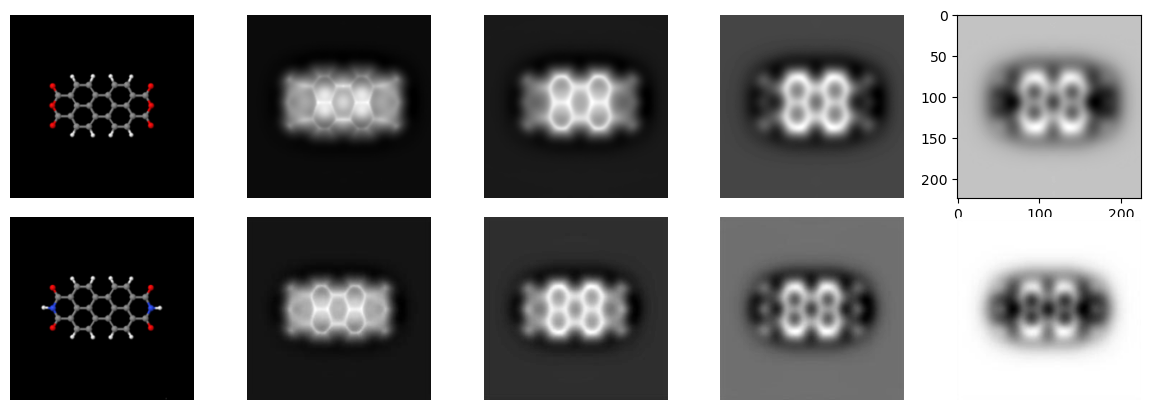

In [5]:
## Make identification figure for Ag
ptcda_CID = 67191

# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
ptcda_path = '/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_gas/K14'
        
exp_img = load_exp_img_stack(ptcda_path, dimensions = [224,224], zoom=1.2)



# Final figure:






# Assuming 'dataset_df' and 'load_img_stack' are already defined in your context
ptcda_nh_CID = 66475
ptcda_nh_path = '/scratch/dataset/quam/K-14/Conformer3D_CID_66475_K080_Amp060'
img_stack_nh = load_img_stack(ptcda_nh_path)

# Creating subplots
f, axarr = plt.subplots(2, 5, figsize=(15, 5))

# Adjusting layout for minimal spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Displaying each image in the grid
jmol_img = load_jmol_image(ptcda_CID, dimension=[224,224], zoom=1)
axarr[0, 0].imshow(jmol_img)
axarr[0, 0].axis('off')  # Hiding the axis labels
jmol_img = load_jmol_image(ptcda_nh_CID, dimension=[224,224], zoom=1)
axarr[1, 0].imshow(jmol_img)
axarr[1, 0].axis('off')  # Hiding the axis labels

for j in range(4):
    axarr[0, j+1].imshow(exp_img[j*2+1], cmap='gray')
    axarr[0, j].axis('off')  # Hiding the axis labels
    axarr[0, j+1].imshow(exp_img[j*2+1], cmap='gray')
    axarr[0, j].axis('off')  # Hiding the axis labels
    
    axarr[1, j+1].imshow(img_stack_nh[j*2+1], cmap='gray')
    axarr[1, j+1].axis('off')  # Hiding the axis labels
    axarr[1, j+1].imshow(img_stack_nh[j*2+1], cmap='gray')
    axarr[1, j+1].axis('off')  # Hiding the axis labels
    print(j*2+1)



plt.show()


/tmp/ipykernel_3666754/3214257816.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ptcda_ag_and_nh.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_3666754/3214257816.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ptcda_ag_and_nh.pdf', dpi=500, format='pdf', quality=120, optimize=True)


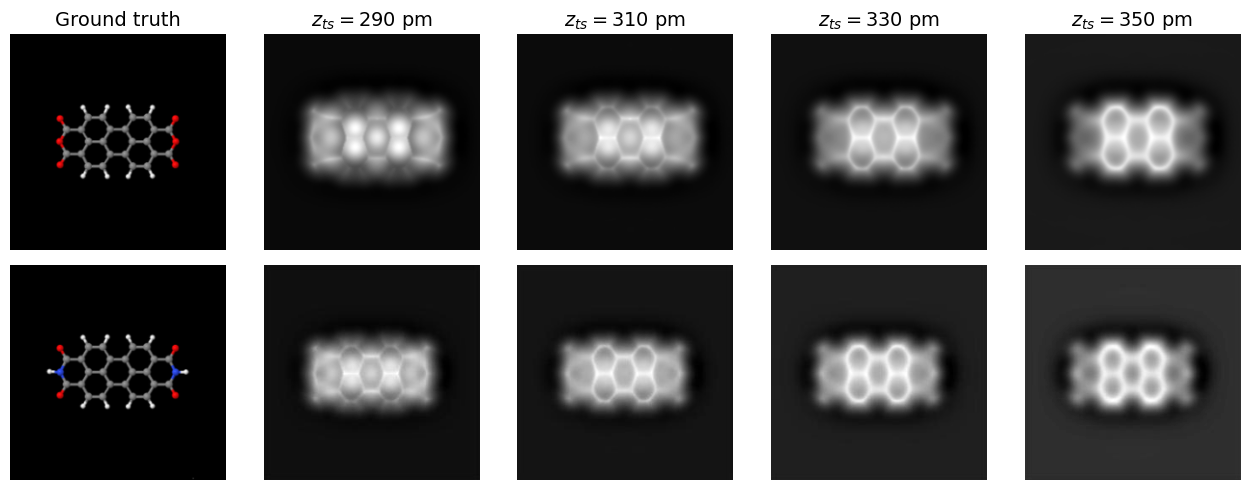

In [17]:
import matplotlib.pyplot as plt

# Assuming 'load_exp_img_stack', 'load_img_stack', and 'load_jmol_image' are defined in your context
ptcda_CID = 67191
ptcda_nh_CID = 66475

ptcda_path = '/home/mgonzalez/PTCDA_simulations_ppm_jaime/PTCDA_gas/K14'
ptcda_nh_path = '/scratch/dataset/quam/K-14/Conformer3D_CID_66475_K080_Amp060'

exp_img = load_exp_img_stack(ptcda_path, dimensions=[224, 224], zoom=1.2)
img_stack_nh = load_img_stack(ptcda_nh_path)

# Creating subplots
f, axarr = plt.subplots(2, 5, figsize=(13, 5))
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjusting layout

# Titles for each column
column_titles = ['Ground truth', '$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm',  '$z_{ts}=350$ pm']

# Displaying Jmol images in the first column
jmol_img = load_jmol_image(ptcda_CID, dimension=[224, 224], zoom=1)
axarr[0, 0].imshow(jmol_img)
axarr[0, 0].axis('off')

jmol_img_nh = load_jmol_image(ptcda_nh_CID, dimension=[224, 224], zoom=1)
axarr[1, 0].imshow(jmol_img_nh)
axarr[1, 0].axis('off')

# Displaying experimental and simulated images
for j in range(4):
    axarr[0, j+1].imshow(exp_img[j], cmap='gray')
    axarr[0, j+1].axis('off')

    axarr[1, j+1].imshow(img_stack_nh[j], cmap='gray')
    axarr[1, j+1].axis('off')

# Adding titles to each column
for ax, col_title in zip(axarr[0], column_titles):
    ax.set_title(col_title, fontsize=14)
    
plt.tight_layout()
plt.savefig('ptcda_ag_and_nh.pdf', dpi=500, format='pdf', quality=120, optimize=True)


plt.show()


## Image stacks of simulations

/scratch/dataset/quam/K-14/Conformer3D_CID_29766_K080_Amp060
Total number of fingerprints 13
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 29766 tanimoto: 1.0
second candidate: 84676 tanimoto: 0.8571428571428571
########################
338744       29766
340499       84676
327339    23341361
576580    51000077
489450     3084709
Name: CID, dtype: int64
########################
29766 29766 84676
/scratch/dataset/quam/K-24/Conformer3D_CID_67191_K100_Amp140
Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 67191 tanimoto: 1.0
second candidate: 59464606 tanimoto: 1.0
########################
-1       67191
 0    59464606
 1    59464606
 2    59464606
 3    59464606
Name: CID, dtype: int64
########################
67191 67191 59464606
/scratch/dataset/quam/K-18/Conformer3D_CID_13615479_K080_Amp140
Total number of fingerprints 15
Is the co

/tmp/ipykernel_587580/3920746464.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = dataset_df.append({'path':path,


torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
25
                                                     path        CID  \
579911                                               /aaa   88955426   
275257  /scratch/dataset/quam/K-1/Conformer3D_CID_1304...  130412167   
394850  /scratch/dataset/quam/K-1/Conformer3D_CID_8885...   88850427   
68534   /scratch/dataset/quam/K-1/Conformer3D_CID_1357...     135719   
320254  /scratch/dataset/quam/K-1/Conformer3D_CID_1320...  132093176   

                                               SMILES  \
579911     C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24   
275257  C1=CC=C2C(=C1)C3=C(C=CC(=C3)I)C4=C2C=C(C=C4)I   
394850     C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=NC=CN=C24   
68534   C1=CC=C2C(=C1)C3=CC=CC=C3C4=C2C=C5C=CN=CC5=C4   
320254       C1=CC=C2C(=C1)C=CC3=C2C=CC4=C3C=C(C=C4)I   

                                                morgan_fp split  corrugation  \
579911  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

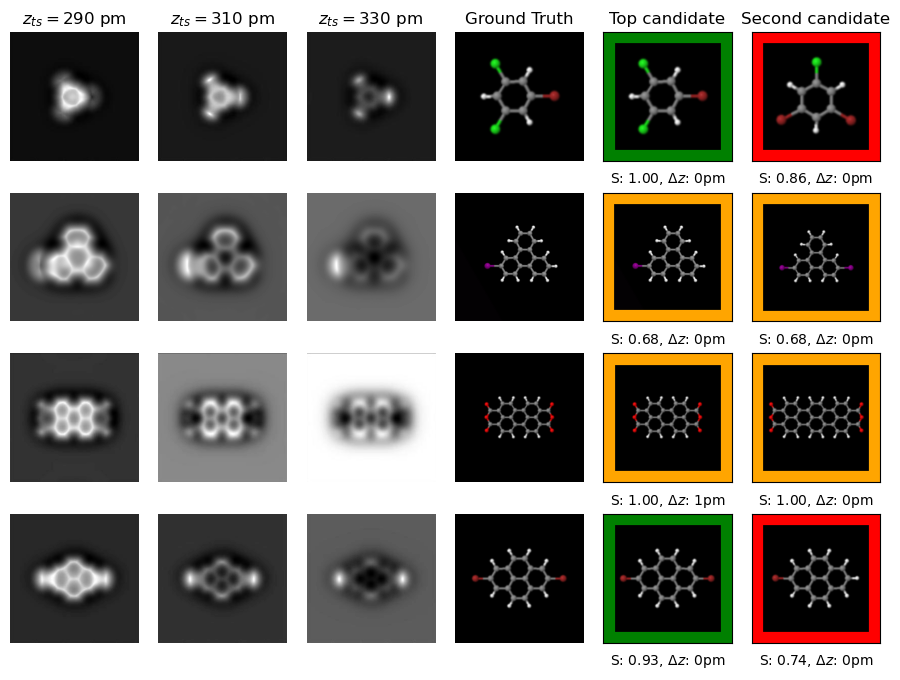

In [31]:
## Final figure

# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=4
molec_paths = ['/scratch/dataset/quam/K-14/Conformer3D_CID_29766_K080_Amp060',  
        '/scratch/dataset/quam/K-24/Conformer3D_CID_67191_K100_Amp140',
        '/scratch/dataset/quam/K-18/Conformer3D_CID_13615479_K080_Amp140']
zoom_list = [0.5, 1.05, 0.75]
test_df = dataset_df
test_df.loc[-2] = test_df[test_df['CID']==67191].iloc[0] # reorder ptcda
test_df.loc[-1] = test_df[test_df['CID']==59464606].iloc[0] # reorder the other candidate

reorder_dict = {0:0, 3:1, 1:2, 2:3} # to reorder the molecules in the plot

test_df.index = test_df.index + 1  # shifting index
test_df = test_df.sort_index()  # sorting by index

titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs
for i in range(n_results):
    if i < 3:
        
        molec_path = molec_paths[i]
        print(molec_path)
        zoom = zoom_list[i]
        img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=zoom, verbose=True)
        print(true_CID, first_CID, second_CID)
        corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
        corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
        ax[reorder_dict[i],0].imshow(img_1, cmap='gray')
        ax[reorder_dict[i],0].axis('off')
        ax[reorder_dict[i],1].imshow(img_3, cmap='gray')
        ax[reorder_dict[i],1].axis('off')
        ax[reorder_dict[i],2].imshow(img_5, cmap='gray')
        ax[reorder_dict[i],2].axis('off')
        ax[reorder_dict[i],3].imshow(gt_jmol)
        ax[reorder_dict[i],3].axis('off')
        ax[reorder_dict[i],4].imshow(first_jmol)
        ax[reorder_dict[i],5].imshow(second_jmol)

        if true_CID == first_CID:
            color = 'green'
            rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
        else:
            color = 'red'
            rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

        if true_CID == second_CID:
            color = 'green'
            rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
        else:
            color = 'red'
            rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     

        if tanimoto_first == tanimoto_second:

            color = 'orange'
            rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
            rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

        ax[reorder_dict[i],4].add_patch(rect)
        ax[reorder_dict[i],5].add_patch(rect_2)
        ax[reorder_dict[i],4].set_xticks([])
        ax[reorder_dict[i],4].set_yticks([])
        ax[reorder_dict[i],5].set_xticks([])
        ax[reorder_dict[i],5].set_yticks([])
        ax[reorder_dict[i],4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
        ax[reorder_dict[i],5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])
    
    if i == 3:
        CID = 88955426
        molec_path = "/home/mgonzalez/2-iodotriphenylene-ppm-jaime/imgs_rlx/K4"

        jmol_path = '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg'
        jmol_img = load_jmol(jmol_path)


        SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
        morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
        split='test'
        corrugation = np.nan
        path = "/aaa"


        experimental_df = dataset_df.append({'path':path,
                                   'CID':CID, 
                                   'SMILES':SMILES,
                                   'morgan_fp':morgan_fp,
                                   'split':split,
                                   'corrugation':corrugation
                                    }, ignore_index=True)


        exp_img = load_exp_img_stack(molec_path, dimensions = [224,224], zoom=1.2, interpolation='bilinear')
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
            print(batched_tensor.size())
            predictions = model(batched_tensor)
            print(predictions.size())
            fp_pred = (torch.sigmoid(predictions) > 0.5)
            print(fp_pred.size())

        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
        print(exp_fp.shape)
        print(exp_fp.sum())

        output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)
        print(output_df)

        



        img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

        gt_jmol = rotate_image(jmol_img, angle=-60)

        pred_CID, second_CID = output_df.iloc[0:2]['CID']
        tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
        print(pred_CID, second_CID)

        pred_jmol = rotate_image(jmol_img, angle=-60)
        second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=1)


        
        ax[reorder_dict[i],0].imshow(img_1, cmap='gray')
        ax[reorder_dict[i],0].axis('off')
        ax[reorder_dict[i],1].imshow(img_3, cmap='gray')
        ax[reorder_dict[i],1].axis('off')
        ax[reorder_dict[i],2].imshow(img_5, cmap='gray')
        ax[reorder_dict[i],2].axis('off')
        ax[reorder_dict[i],3].imshow(gt_jmol)
        ax[reorder_dict[i],3].axis('off')
        ax[reorder_dict[i],4].imshow(pred_jmol)
        ax[reorder_dict[i],5].imshow(second_jmol)
        


        if tanimoto == tanimoto_second:

            color = 'orange'
            rect = patches.Rectangle((0, 0), pred_jmol.shape[0], pred_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')
            rect_2 = patches.Rectangle((0, 0), second_jmol.shape[0], second_jmol.shape[1], linewidth=16, edgecolor=color, facecolor='none')
        
        
                
        ax[reorder_dict[i],4].add_patch(rect)
        ax[reorder_dict[i],5].add_patch(rect_2)
        ax[reorder_dict[i],4].set_xticks([])
        ax[reorder_dict[i],4].set_yticks([])
        ax[reorder_dict[i],5].set_xticks([])
        ax[reorder_dict[i],5].set_yticks([])
        ax[reorder_dict[i],4].set_xlabel(f'S: {tanimoto:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
        ax[reorder_dict[i],5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

      

######################################

plt.tight_layout()
#plt.savefig('ident_exp_molecules_theoretical_imgs.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()

/tmp/ipykernel_587580/3546939675.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('exp_imgs_theoretical_simulations.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_587580/3546939675.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('exp_imgs_theoretical_simulations.pdf', dpi=500, format='pdf', quality=120, optimize=True)


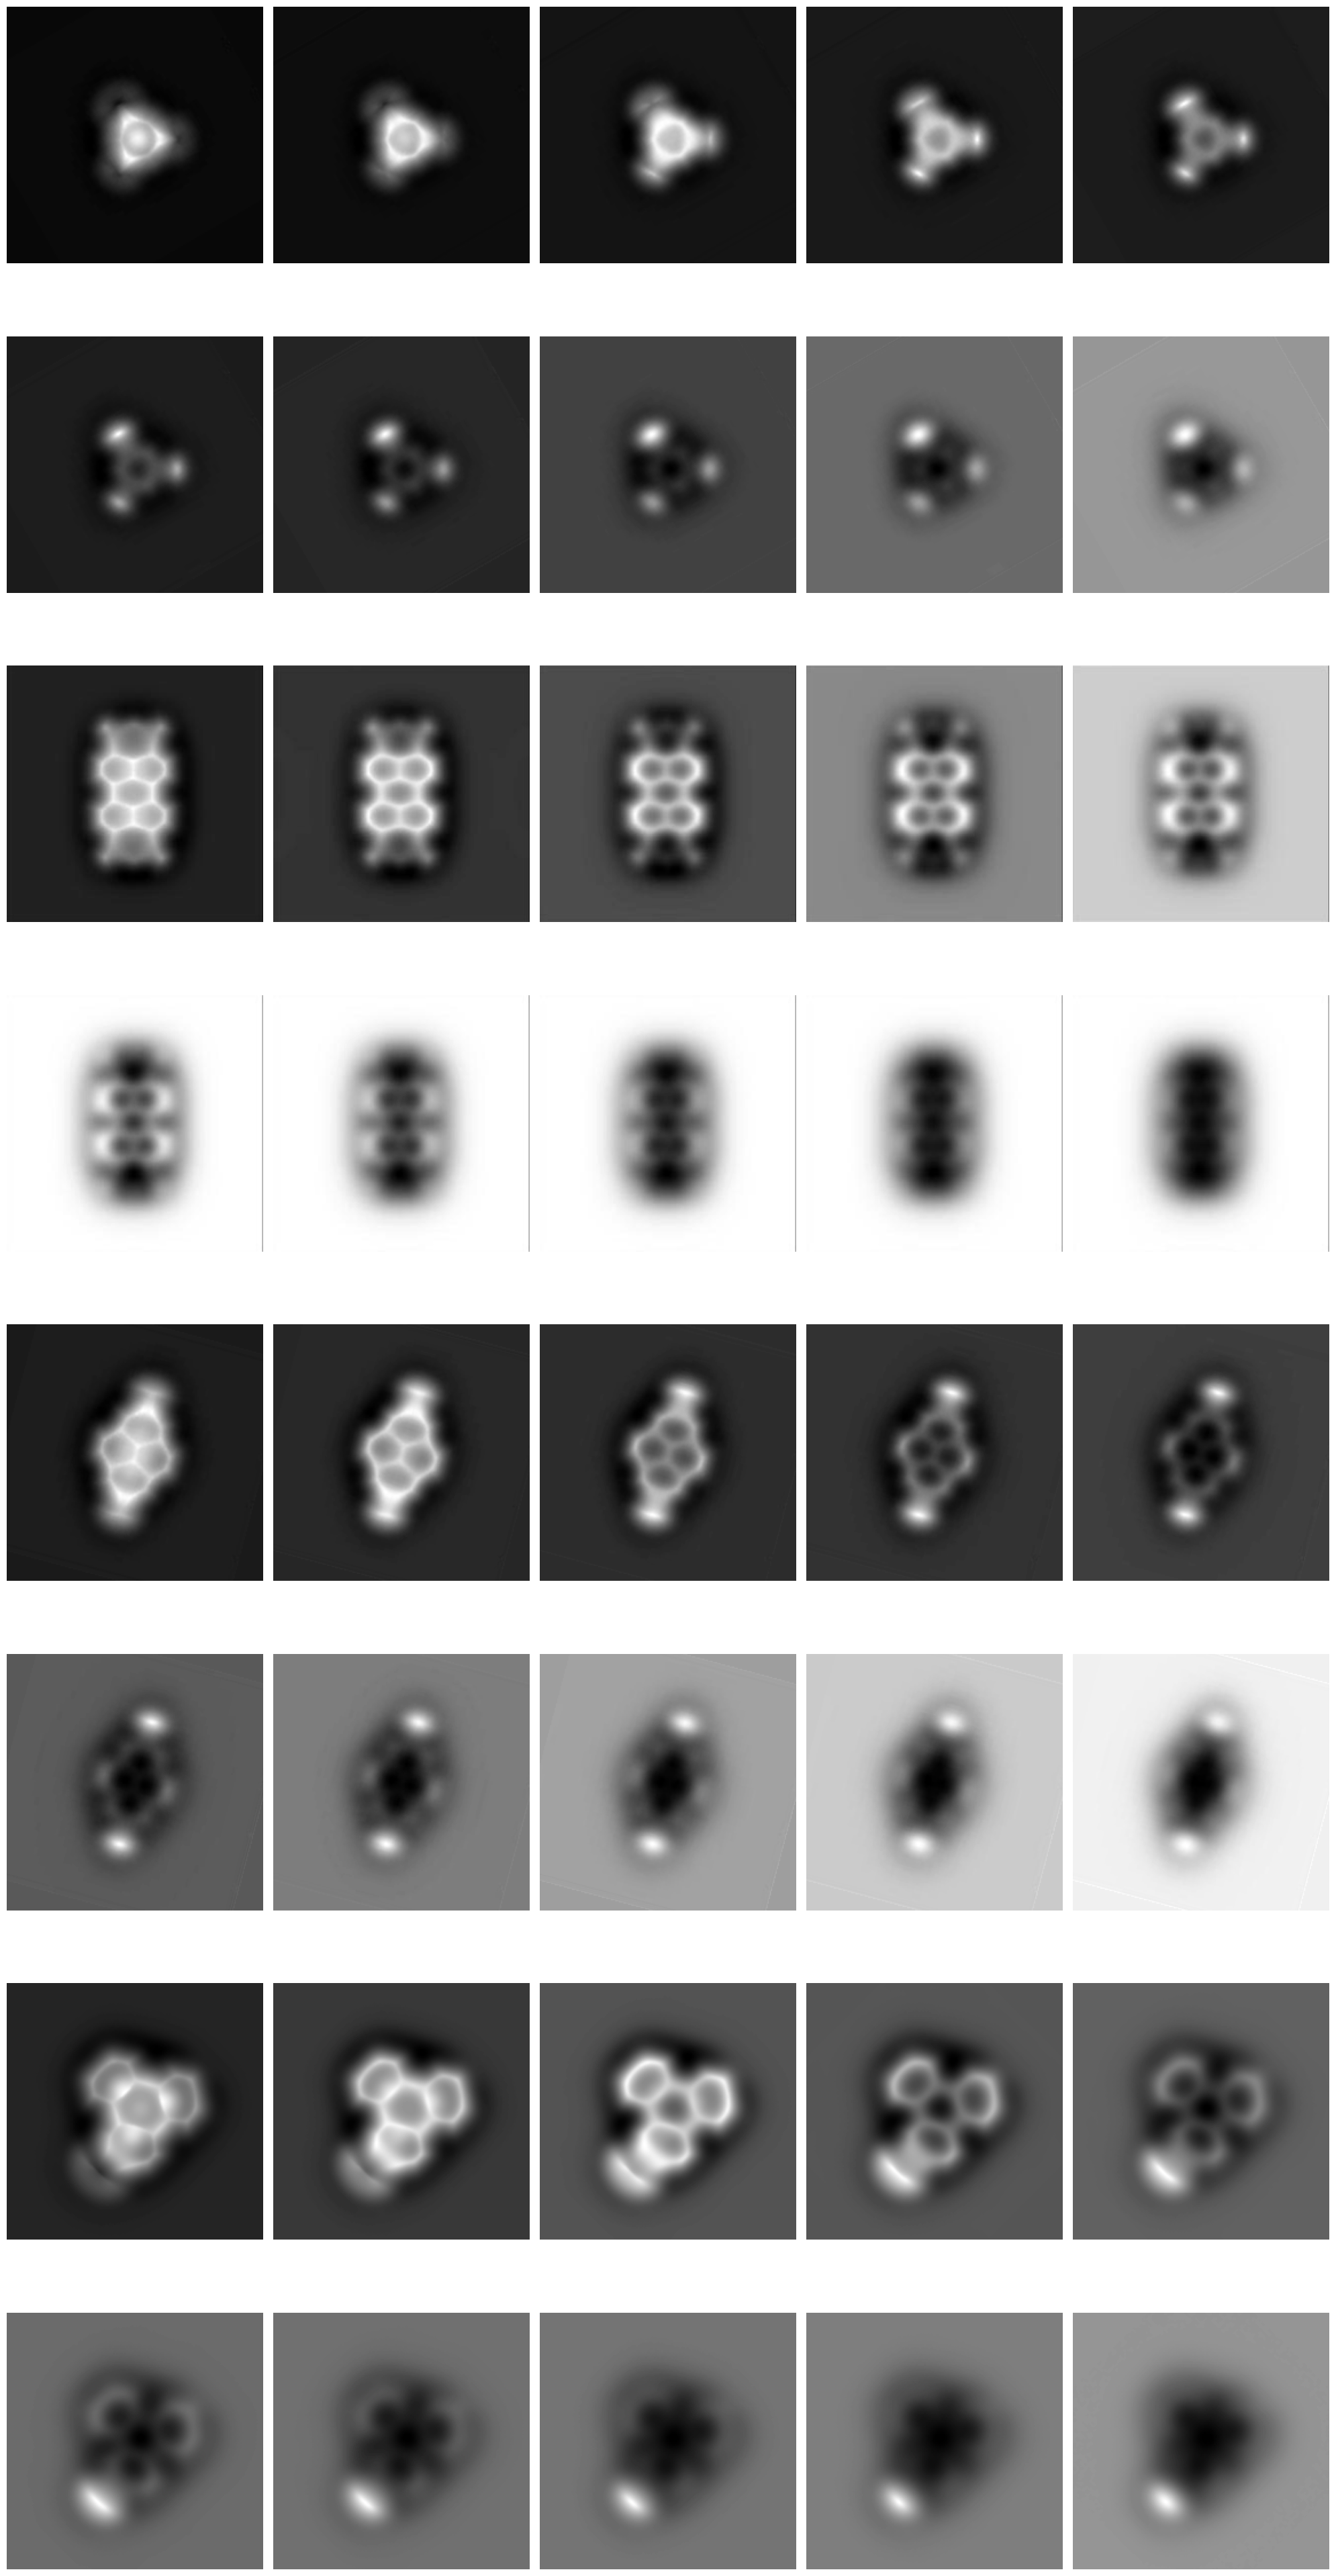

In [90]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
n_results=4
# Paths to the molecules' images directories (assuming each directory contains 10 images for simplicity)
molec_paths = [
    '/scratch/dataset/quam/K-14/Conformer3D_CID_29766_K080_Amp060',  
    '/scratch/dataset/quam/K-24/Conformer3D_CID_67191_K100_Amp140',
    '/scratch/dataset/quam/K-18/Conformer3D_CID_13615479_K080_Amp140',
    "/home/mgonzalez/2-iodotriphenylene-ppm-jaime/imgs_rlx/K4"
]

rotation_list = [-120, 90, -75, -45]

fig, axs = plt.subplots(n_results * 2, 5, figsize=(20, 5 * n_results * 2))  # Adjust figsize according to your needs

for i in range(n_results):
    if i<3:
        img_stack = load_exp_img_stack(molec_paths[i], dimensions=[224, 224], 
                                       rotation=rotation_list[i], interpolation='bilinear')
    else:
        img_stack = load_exp_img_stack(molec_paths[i], dimensions=[224, 224], 
                                   rotation=rotation_list[i], interpolation='bilinear', fill_pixel=(5, 5), zoom=1.2)
    
    for j, img in enumerate(img_stack):
        # Calculate the appropriate row and column indices for the current image
        row = i * 2 + j // 5
        col = j % 5
        axs[row, col].imshow(img, cmap='gray')
        axs[row, col].axis('off')  # Remove axes

plt.tight_layout()
plt.savefig('exp_imgs_theoretical_simulations.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
n_results=4
# Paths to the molecules' images directories (assuming each directory contains 10 images for simplicity)
molec_paths = [
    '/scratch/dataset/quam/K-14/Conformer3D_CID_29766_K080_Amp060',  
    '/scratch/dataset/quam/K-24/Conformer3D_CID_67191_K100_Amp140',
    '/scratch/dataset/quam/K-18/Conformer3D_CID_13615479_K080_Amp140',
    "/home/mgonzalez/2-iodotriphenylene-ppm-jaime/imgs_rlx/K4"
]

rotation_list = [-120, 90, -75, -45]

fig, axs = plt.subplots(n_results * 2, 5, figsize=(20, 5 * n_results * 2))  # Adjust figsize according to your needs

for i in range(n_results):
    if i<3:
        img_stack = load_exp_img_stack(molec_paths[i], dimensions=[224, 224], 
                                       rotation=rotation_list[i], interpolation='bilinear')
    else:
        img_stack = load_exp_img_stack(molec_paths[i], dimensions=[224, 224], 
                                   rotation=rotation_list[i], interpolation='bilinear', fill_pixel=(5, 5), zoom=1.2)
    
    for j, img in enumerate(img_stack):
        # Calculate the appropriate row and column indices for the current image
        row = i * 2 + j // 5
        col = j % 5
        axs[row, col].imshow(img, cmap='gray')
        axs[row, col].axis('off')  # Remove axes

plt.tight_layout()
plt.savefig('exp_imgs_theoretical_simulations.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()

/tmp/ipykernel_587580/1862383030.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('exp_imgs_stacks_with_zooms.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_587580/1862383030.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('exp_imgs_stacks_with_zooms.pdf', dpi=500, format='pdf', quality=120, optimize=True)


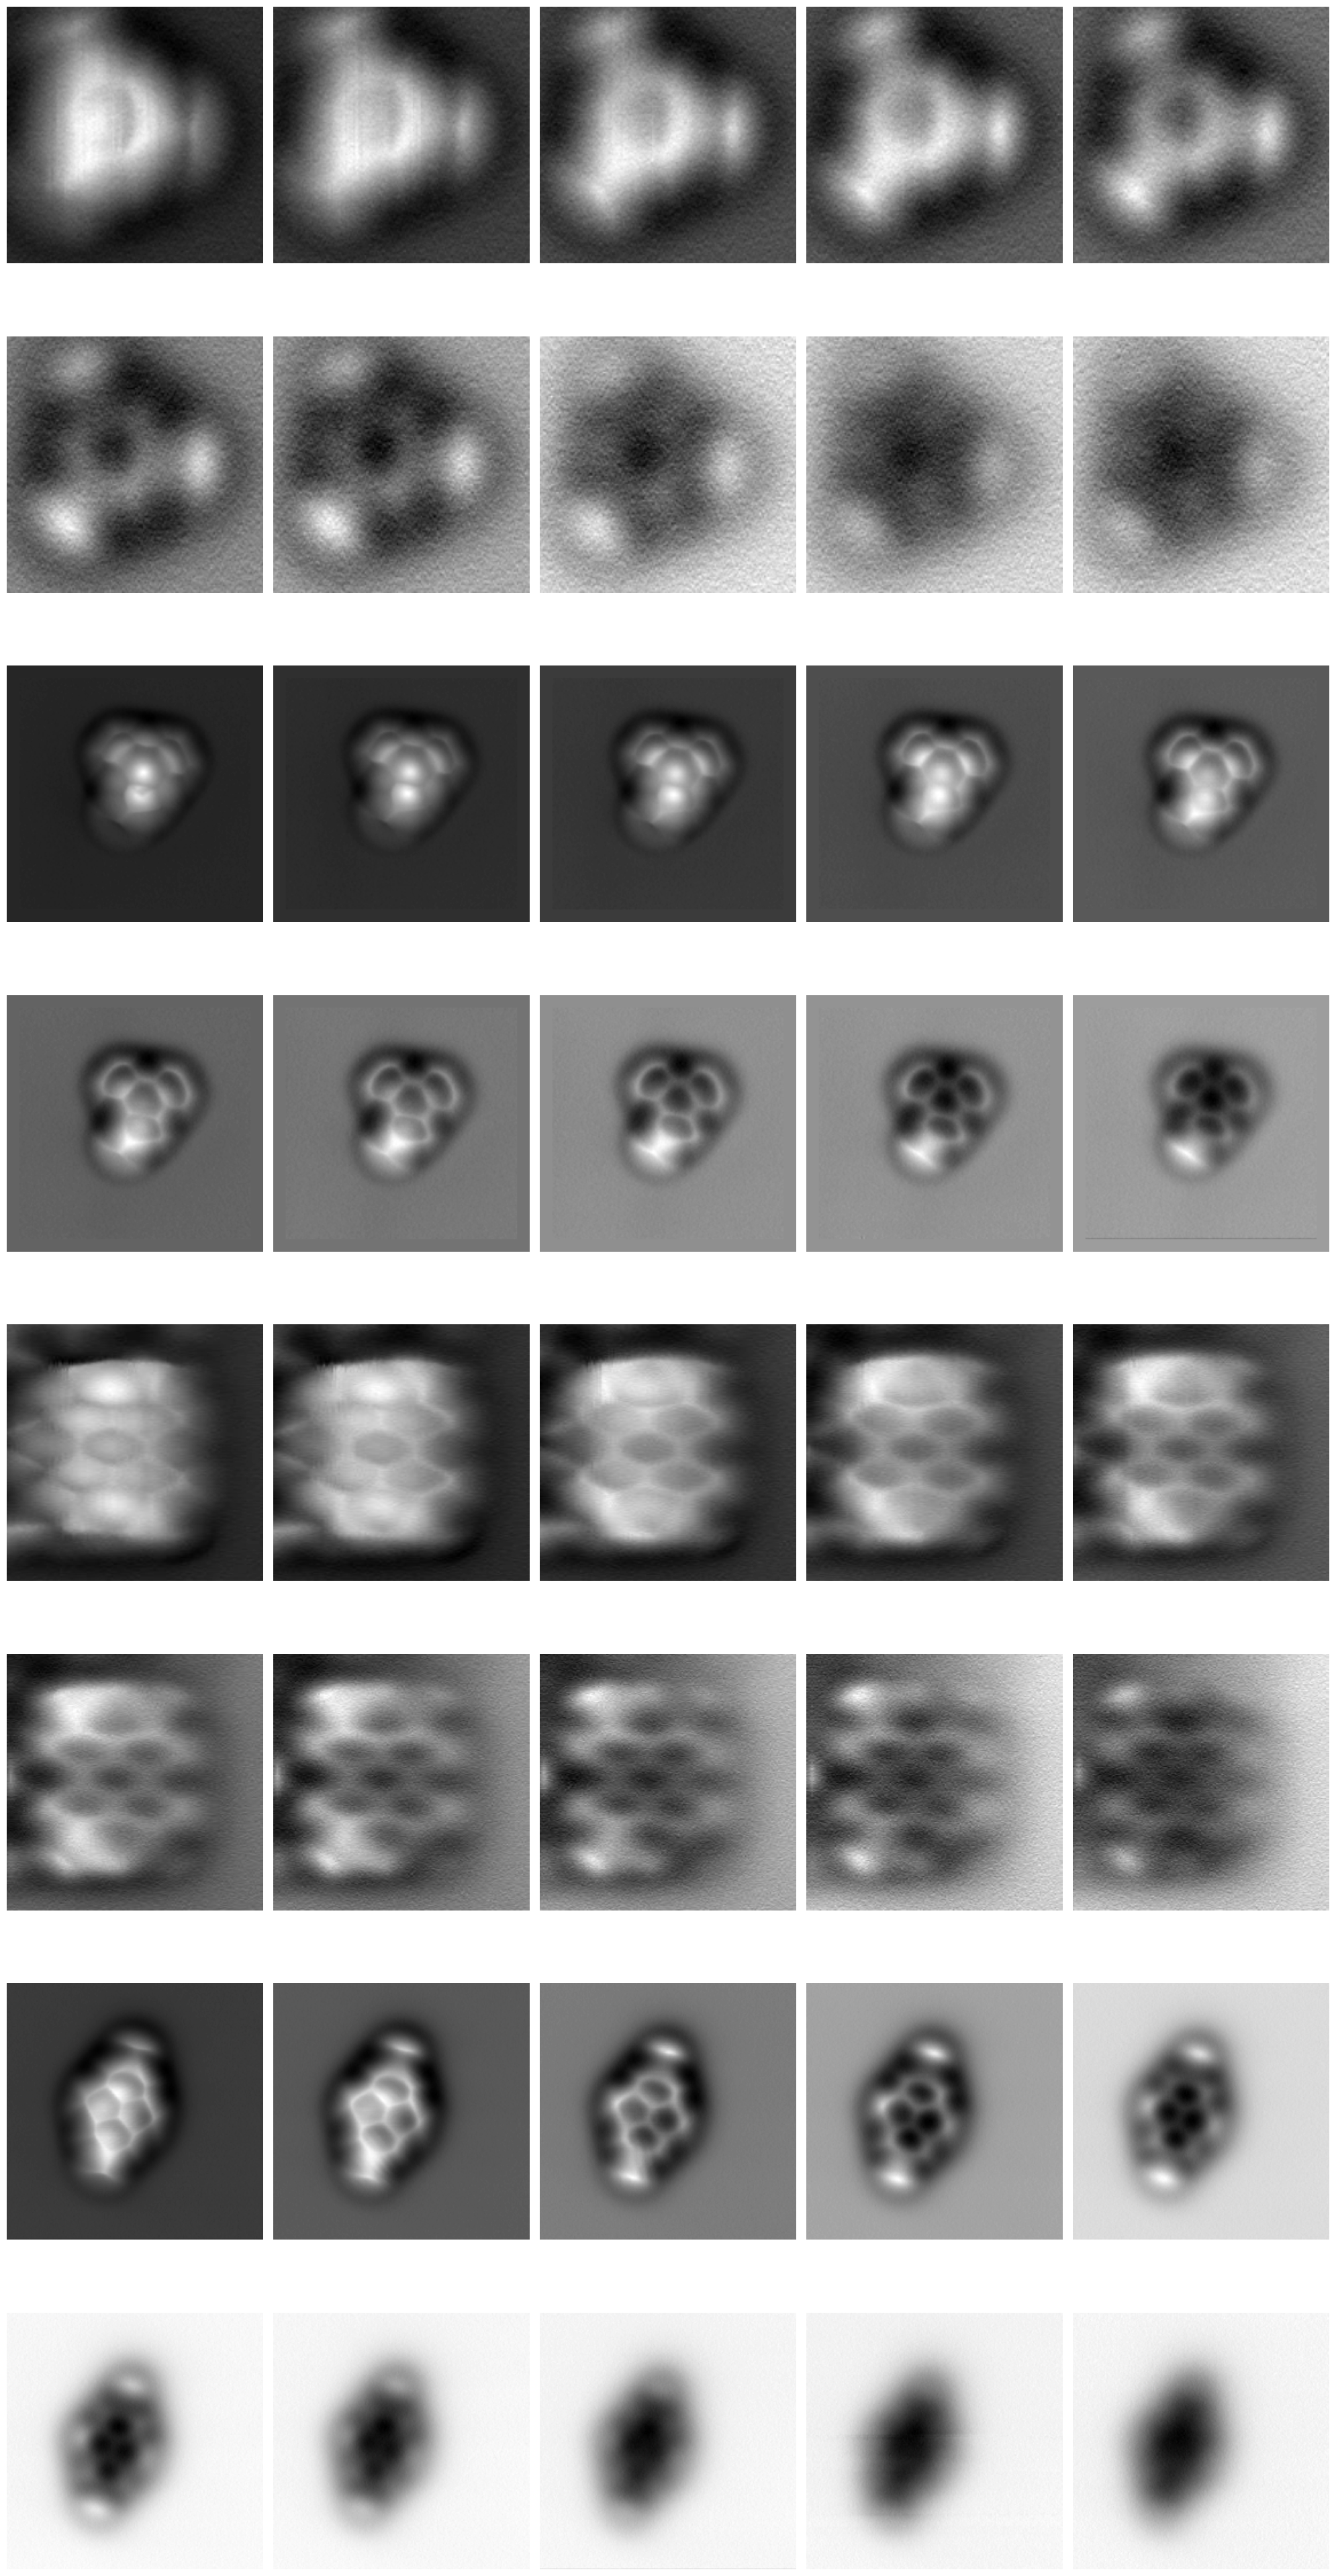

In [97]:
n_results = 4
path_list = [f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further'
             ]
zoom_list = [1.4, 0.9 , 1, 1]
fig, axs = plt.subplots(n_results * 2, 5, figsize=(20, 5 * n_results * 2))  # Adjust figsize according to your needs

for i in range(n_results):
    img_stack = load_exp_img_stack(path_list[i], dimensions=[224, 224], 
                                       zoom=zoom_list[i], interpolation='bilinear')

    
    for j, img in enumerate(img_stack):
        # Calculate the appropriate row and column indices for the current image
        row = i * 2 + j // 5
        col = j % 5
        axs[row, col].imshow(img, cmap='gray')
        axs[row, col].axis('off')  # Remove axes

plt.tight_layout()
plt.savefig('exp_imgs_stacks_with_zooms.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()



